In [ ]:
# different iter
# switch to CPU!!!
!pip install faiss-cpu
import numpy as np
import pandas as pd
import faiss
import time
from pathlib import Path
import gc
from scipy.linalg import orth # For creating orthogonal matrices

class FCFC:
    def __init__(self, d, k, niter=25, nredo=1, verbose=False,
                    min_points_per_centroid=1, max_points_per_centroid=1000000000,
                    seed=1234, gpu=False, spherical=False,
                    update_index=True, frozen_centroids=False,
                    lambda_=1.0):
        # d: dimensionality of data
        # k: number of clusters
        self.d_features = d # Renamed for clarity, consistent with other classes
        self.k = k
        self.niter = niter
        self.max_iter = niter # Keep for consistency with existing loop

        # Other parameters (some might not be used by this specific FCFC logic but kept for interface)
        self.nredo = nredo
        self.verbose = verbose
        self.min_points_per_centroid = min_points_per_centroid
        self.max_points_per_centroid = max_points_per_centroid
        self.seed = seed
        self.gpu = gpu # This FCFC implementation is CPU-based
        self.spherical = spherical
        self.update_index = update_index
        self.frozen_centroids = frozen_centroids
        self.lambda_ = lambda_  # Balance parameter for the objective function in get_distance

        # Results storage
        self.centroids = None               # Final cluster centroids (k, d_features)
        self.labels_ = None                 # Final cluster assignments for each point (n_samples,)
        self.runtime_ = None                # Total training time

        self.objective_history_ = None      # History of sum_dis (sum of D(i,j) values)
        self.sse_history_ = None            # History of Sum of Squared Errors per iteration
        self.balance_loss_history_ = None   # History of Balance Loss per iteration

        self.final_objective_ = None        # Final value from objective_history_
        self.final_sse_ = None              # Final Sum of Squared Errors
        self.final_balance_loss_ = None     # Final Balance Loss
        self.final_cluster_sizes_ = None    # Final size of each cluster (k,)

        self.sse_ = 0
        self.balance_loss_ = 0

        # For compatibility, self.obj can point to the primary objective history
        self.obj = None


    def train(self, x, weights=None, init_centroids_arg=None): # Renamed init_centroids to avoid conflict
        np.random.seed(self.seed) # Set seed for reproducibility
        start_time = time.time()

        K = self.k
        if x.shape[1] != self.d_features:
            raise ValueError(f"Input data feature dimension {x.shape[1]} "
                             f"does not match class initialized dimension {self.d_features}")
        n_samples, d_features_data = x.shape # n_samples, d in original code

        # Initialize arrays for storing per-iteration metrics
        # sse_history stores the traditional SSE
        # balance_loss_history stores the balance penalty
        # objective_value_history stores the sum of D(i,j) which is being minimized directly
        sse_history = np.zeros(self.max_iter)
        balance_loss_history = np.zeros(self.max_iter)
        objective_value_history = np.zeros(self.max_iter) # Corresponds to pre_dis

        # Initialize centroids
        # If init_centroids_arg is provided, use it, otherwise use random initialization
        if init_centroids_arg is not None:
            if init_centroids_arg.shape != (K, d_features_data):
                raise ValueError(f"Provided init_centroids shape {init_centroids_arg.shape} "
                                 f"is not ({K}, {d_features_data})")
            current_centroids = np.copy(init_centroids_arg)
        else:
            current_centroids = initial_centroid(x, K, n_samples) # Uses np.random internally

        # size_cluster is 1*K vector, stores size of each cluster for the get_distance objective
        # Initialized to ones to avoid issues if lambda_ > 0 and a cluster is initially empty,
        # though it gets updated immediately in the first iteration.
        # A more common initialization might be n_samples/K or based on initial assignment.
        # Let's base it on an initial quick assignment or n_samples/K to be more robust.
        # For simplicity of matching the provided code, it starts with ones and is quickly updated.
        current_size_cluster = np.ones(K) # Will be updated after first assignment

        current_labels = np.zeros(n_samples, dtype=int) # To store labels for each point

        for i in range(self.max_iter):
            # Assignment step: Calculate D matrix and assign points to clusters
            # D(point, cluster_j) = distance(point, centroid_j)^2 + lambda * size_cluster_j
            D_matrix = get_distance(x, current_centroids, K, n_samples, d_features_data,
                                    current_size_cluster, self.lambda_)

            min_dist_to_centroid_plus_balance = np.min(D_matrix, axis=1) # (n_samples,)
            assigned_labels = np.argmin(D_matrix, axis=1)           # (n_samples,)
            sum_objective_values = np.sum(min_dist_to_centroid_plus_balance)

            current_labels = assigned_labels
            objective_value_history[i] = sum_objective_values

            # Update step: Recalculate centroids and cluster sizes
            # current_size_cluster is based on the new assignments
            current_size_cluster = np.bincount(current_labels, minlength=K)
            current_centroids = get_centroid(x, current_labels, K, n_samples, d_features_data)

            # Calculate SSE and Balance Loss for this iteration (for monitoring)
            iter_sse = 0
            iter_balance_penalty_terms = np.zeros(K)

            for j in range(K):
                cluster_points = x[current_labels == j, :]
                if cluster_points.shape[0] > 0: # If cluster is not empty
                    # SSE part: sum of squared distances to its actual centroid
                    iter_sse += np.sum(np.sum((cluster_points - current_centroids[j, :])**2, axis=1))
                # Balance loss part (using current_size_cluster which is already updated)
                iter_balance_penalty_terms[j] = (current_size_cluster[j] - n_samples / K)**2

            sse_history[i] = iter_sse
            balance_loss_history[i] = np.sum(iter_balance_penalty_terms)

            if self.verbose and (i % 5 == 0 or i == self.max_iter -1) :
                print(f"Iter {i+1}/{self.max_iter}: Objective={objective_value_history[i]:.4f}, "
                      f"SSE={sse_history[i]:.4f}, BalanceLoss={balance_loss_history[i]:.4f}")

        self.runtime_ = time.time() - start_time

        # Store results
        self.centroids = current_centroids
        self.labels_ = current_labels
        self.final_cluster_sizes_ = current_size_cluster

        self.objective_history_ = objective_value_history
        self.sse_history_ = sse_history
        self.balance_loss_history_ = balance_loss_history

        self.final_objective_ = objective_value_history[-1]
        self.final_sse_ = sse_history[-1]
        self.final_balance_loss_ = balance_loss_history[-1]

        self.obj = self.objective_history_ # Storing the history of the optimized objective

        self.sse_ = self.final_sse_
        self.balance_loss_ = self.final_balance_loss_

        if self.verbose:
            print(f"FCFC training completed in {self.runtime_:.4f} seconds.")
            print(f"Final Objective (sum of D(i,j)): {self.final_objective_:.4f}")
            print(f"Final SSE: {self.final_sse_:.4f}")
            print(f"Final Balance Loss: {self.final_balance_loss_:.4f}")
            print(f"Final cluster sizes: {self.final_cluster_sizes_}")

class Lloyd:
    def __init__(self, d, k, niter=25, nredo=1, verbose=False,
                 min_points_per_centroid=1, max_points_per_centroid=1000000,
                 seed=1234, gpu=False, spherical=False,
                 update_index=True, frozen_centroids=False):
        # 保持与faiss.Kmeans完全相同的参数
        self.d = d
        self.k = k
        self.niter = niter
        self.nredo = nredo
        self.verbose = verbose
        self.min_points_per_centroid = min_points_per_centroid
        self.max_points_per_centroid = max_points_per_centroid
        self.seed = seed
        self.gpu = gpu
        self.spherical = spherical
        self.update_index = update_index
        self.frozen_centroids = frozen_centroids

        # 结果存储
        self.centroids = None
        self.runtime_ = None
        self.obj = None

    def train(self, x, weights=None, init_centroids=None):
        start_time = time.time()
        # 初始化中心点
        if init_centroids is not None:
            self.centroids = init_centroids.copy()
        else:
            np.random.seed(self.seed)
            self.centroids = x[np.random.choice(
                x.shape[0], self.k, replace=False)]

        for _ in range(self.niter):
            # 分配样本到最近的中心点
            distances = np.linalg.norm(
                x[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)

            # 更新中心点
            new_centroids = np.zeros_like(self.centroids)
            counts = np.zeros(self.k)

            for i in range(x.shape[0]):
                cluster_idx = labels[i]
                new_centroids[cluster_idx] += x[i]
                counts[cluster_idx] += 1

            # 处理空簇
            for j in range(self.k):
                if counts[j] > 0:
                    new_centroids[j] /= counts[j]
                else:
                    # 空簇处理策略：随机选择一个样本作为新中心
                    new_centroids[j] = x[np.random.randint(x.shape[0])]

            # 检查收敛
            if np.linalg.norm(new_centroids - self.centroids) < 1e-6:
                break

            self.centroids = new_centroids


        # 计算目标函数值(SSE)
        # self.obj = np.sum(np.min(np.linalg.norm(
        #     x[:, np.newaxis] - self.centroids, axis=2), axis=1)**2)

        # 转换为float32类型（FAISS要求）
        x = np.ascontiguousarray(x, dtype='float32')

        # 创建FAISS K-means对象
        kmeans = faiss.Kmeans(
            d=self.d,
            k=self.k,
            niter=self.niter,
            nredo=self.nredo,
            verbose=self.verbose,
            min_points_per_centroid=self.min_points_per_centroid,
            max_points_per_centroid=self.max_points_per_centroid,
            seed=self.seed,
            gpu=self.gpu,
            spherical=self.spherical,
            update_index=self.update_index,
            frozen_centroids=self.frozen_centroids
        )

        # 训练
        kmeans.train(x, init_centroids=init_centroids)
        self.runtime_ = time.time() - start_time

        # 保存结果
        self.centroids = kmeans.centroids
        # self.obj = kmeans.obj[-1] if kmeans.obj else None
        self.obj = kmeans.obj[-1] if kmeans.obj.size > 0 else None

class BCLS:
    def __init__(self, d, k, niter=25, nredo=1, verbose=False,
                 min_points_per_centroid=1, max_points_per_centroid=1e9,
                 seed=1234, gpu=False, spherical=False,
                 update_index=True, frozen_centroids=False,
                 lambda_=1.0): # lambda_ from FCFC, but BCLS uses 'lam' internally
        # d: dimensionality of data
        # k: number of clusters
        self.d = d
        self.k = k
        self.niter = niter
        self.nredo = nredo # Not used by BCLS algorithm itself
        self.verbose = verbose
        # The following Faiss-like parameters are not directly used by BCLS's core logic:
        self.min_points_per_centroid = min_points_per_centroid
        self.max_points_per_centroid = max_points_per_centroid
        self.gpu = gpu
        self.spherical = spherical
        self.update_index = update_index
        self.frozen_centroids = frozen_centroids

        self.seed = seed
        self.lambda_bcls = lambda_ # BCLS specific lambda for sum_Y term in objective
                                  # If the lambda_ parameter was meant for this, it's used as 'lam' below.
                                  # If it was for something else, then 'lam' needs its own source.
                                  # Assuming lambda_ is the 'lam' for BCLS objective.

        # Results storage
        self.centroids = None       # Will store centroids in original data space
        self.obj_history_ = None    # Stores Obj2 from the loop
        self.labels_ = None         # Final cluster assignments (0-indexed)
        self.Y_final_ = None        # Final Y matrix (one-hot indicators)

        # Final metrics
        self.sse_ = None
        self.balance_loss_ = None
        self.runtime_ = None

        # For compatibility with previous structure if any part expects 'obj'
        self.obj = None


    def init1(self, n_samples, num_clusters):
        """
        Initializes the Y matrix (n_samples x num_clusters) with one-hot encoding.
        Labels are 1 to num_clusters, then converted to 0-indexed for Python.
        """
        # np.random is affected by self.seed if set before calling train
        labels_1_indexed = np.random.randint(1, num_clusters + 1, size=n_samples)
        F = np.zeros((n_samples, num_clusters))
        F[np.arange(n_samples), labels_1_indexed - 1] = 1
        # F = csr_matrix(F) # Can be sparse if n and k are very large
        return F

    def compute_centroids_from_data(self, data_points, labels, num_clusters, data_dim):
        """
        Calculates centroids from data points and their labels.
        data_points: (n_samples, n_features) - original or centered
        labels: (n_samples,) - 0-indexed
        num_clusters: k
        data_dim: d
        Returns: (num_clusters, data_dim) centroids
        """
        centroids = np.zeros((num_clusters, data_dim), dtype=np.float32)
        counts = np.zeros(num_clusters, dtype=int)

        if labels is None:
            if self.verbose:
                print("Warning: Labels are None in compute_centroids_from_data. Returning zero centroids.")
            return centroids

        for i in range(len(data_points)):
            label = labels[i]
            centroids[label] += data_points[i, :]
            counts[label] += 1

        for j in range(num_clusters):
            if counts[j] > 0:
                centroids[j] /= counts[j]
            else:
                if self.verbose:
                    print(f"Warning: Cluster {j} is empty. Assigning a random data point as its centroid.")
                if len(data_points) > 0:
                    # Seed this random choice for consistency if multiple empty clusters
                    rng_empty_fallback = np.random.RandomState(self.seed + j + 1000) # Offset seed
                    centroids[j] = data_points[rng_empty_fallback.choice(len(data_points)), :]
                # else: centroids[j] remains zeros
        return centroids


    def train(self, x_orig_data, weights=None, init_centroids=None): # x_orig_data is n x dim
        np.random.seed(self.seed) # Ensure reproducibility for operations within train
        start_time = time.time()

        if x_orig_data.shape[1] != self.d:
            raise ValueError(f"Input data feature dimension {x_orig_data.shape[1]} "
                             f"does not match class initialized dimension {self.d}")

        ITER = self.niter
        # BCLS Algorithm Hyperparameters (taken from the provided snippet)
        gamma = 0.00001  # Regularization for W
        lam = self.lambda_bcls # Controls balance term in objective (sum_Y**2)
        mu = 0.01        # ALM parameter

        n, dim = x_orig_data.shape
        c = self.k  # number of clusters

        # Initialize Y
        Y = self.init1(n, c) # Y is n x c

        # Center the data (BCLS works with centered data)
        meanX = np.mean(x_orig_data, axis=0, keepdims=True) # 1 x dim
        x_centered = x_orig_data - meanX # n x dim

        # ALM variables
        Lambda_alm = np.zeros((n, c)) # Lagrange multipliers for Y - Z = 0
        rho = 1.005                # Update factor for mu

        # Precompute part of W update
        # P_inv = x_centered.T @ x_centered + gamma * np.eye(dim)
        # P = np.linalg.inv(P_inv)
        # Using pseudo-inverse for potentially better stability if P_inv is singular/ill-conditioned
        try:
            P = np.linalg.inv(x_centered.T @ x_centered + gamma * np.eye(dim))
        except np.linalg.LinAlgError:
            if self.verbose:
                print("Warning: Standard inverse failed for P. Using pseudo-inverse.")
            P = np.linalg.pinv(x_centered.T @ x_centered + gamma * np.eye(dim))


        obj_history = np.zeros(ITER)
        # Optional: if you want to track SSE/BalanceLoss per iteration (on centered data)
        # sse_iter_history = np.zeros(ITER)
        # balance_loss_iter_history = np.zeros(ITER)


        for iter_idx in range(ITER):
            # --- Solve W and b ---
            # W: dim x c, b: 1 x c
            W = P @ (x_centered.T @ Y)
            b = np.mean(Y, axis=0, keepdims=True) # Or (1/n) * (np.ones((1,n)) @ Y)

            # E = XW + 1b' - Y (Error term for reconstruction using centered X)
            # E_recon: n x c
            E_recon = x_centered @ W + np.ones((n, 1)) @ b - Y

            # --- Solve Z (auxiliary variable for Y) ---
            # Z: n x c
            # Denominator matrix for Z update:
            # Factor = mu**2 + 2 * n * lam * mu  (scalar)
            # Coeff_matrix_inv = (-2 * lam * np.ones((n,n)) + (mu + 2 * n * lam) * np.eye(n)) / Factor
            # Z = Coeff_matrix_inv @ (mu * Y + Lambda_alm)
            # Simpler if Z is updated element-wise or if structure allows.
            # The provided formula for Z seems like a direct solution from a specific formulation.
            # Let's assume the formula is correct as given:
            # Note: (mu**2 + 2 * n * lam * mu) is a scalar.
            # The matrix to invert for Z is effectively ( (mu + 2*n*lam)*I - 2*lam*J ), where J is all-ones matrix.
            # This matrix has a specific inverse (Sherman-Woodbury).
            # For now, using the provided direct calculation:
            mat_for_Z_inv_num = -2 * lam * np.ones((n, n)) + (mu + 2 * n * lam) * np.eye(n)
            mat_for_Z_inv_den = (mu**2 + 2 * n * lam * mu)
            if np.abs(mat_for_Z_inv_den) < 1e-9: # Avoid division by zero
                 if self.verbose: print(f"Warning: Denominator for Z is near zero at iter {iter_idx}")
                 Z = Y # Fallback or handle error
            else:
                 Z = (mat_for_Z_inv_num / mat_for_Z_inv_den) @ (mu * Y + Lambda_alm)


            # --- Solve Y (indicator matrix) ---
            # V: n x c
            V_update = (1 / (2 + mu)) * (2 * x_centered @ W + 2 * np.ones((n, 1)) @ b + mu * Z - Lambda_alm)

            # Update Y by selecting the max element in each row of V_update
            current_labels = np.argmax(V_update, axis=1) # n-element array of 0-indexed labels
            Y = np.zeros((n, c))
            Y[np.arange(n), current_labels] = 1

            # --- Update Lambda (Lagrange multipliers) and mu (penalty parameter) for ALM ---
            Lambda_alm = Lambda_alm + mu * (Y - Z)
            mu = min(mu * rho, 1e5) # Cap mu to avoid very large values

            # --- Calculate Objective Value (for centered data) ---
            sum_Y_elements = np.sum(Y) # Sum of all elements in Y (should be n if Y is strictly one-hot)
            obj_history[iter_idx] = np.trace(E_recon.T @ E_recon) + \
                                    gamma * np.trace(W.T @ W) + \
                                    lam * (sum_Y_elements**2) # Or lam * np.sum( (np.sum(Y, axis=0) - n/c)**2 ) if balance is per cluster size


            # --- In-loop SSE and Balance Loss (on centered data, for monitoring if needed) ---
            # These are calculated based on current Y and centered data.
            # Centroids for centered data: c x dim
            temp_centroids_centered = self.compute_centroids_from_data(x_centered, current_labels, c, dim)

            sse_iter = 0
            for i in range(n):
                cluster_idx = current_labels[i]
                # Using np.sum for squared norm for clarity with dimensions
                sse_iter += np.sum((x_centered[i, :] - temp_centroids_centered[cluster_idx, :])**2)
            # sse_iter_history[iter_idx] = sse_iter

            cluster_sizes_iter = np.sum(Y, axis=0) # n_elements per cluster (1 x c)
            ideal_size_iter = n / c
            balance_loss_iter = np.sum((cluster_sizes_iter - ideal_size_iter)**2)
            # balance_loss_iter_history[iter_idx] = balance_loss_iter

            if self.verbose and (iter_idx % 10 == 0 or iter_idx == ITER -1):
                print(f"Iter {iter_idx+1}/{ITER}, BCLS Obj: {obj_history[iter_idx]:.4f}, "
                      f"Iter SSE (centered): {sse_iter:.2f}, Iter Bal (centered): {balance_loss_iter:.2f}")


        # --- End of iterations ---
        self.runtime_ = time.time() - start_time

        # Store final results
        self.labels_ = np.argmax(Y, axis=1) # Final 0-indexed labels
        self.Y_final_ = Y                   # Final one-hot indicator matrix
        self.obj_history_ = obj_history
        self.obj = obj_history # Compatibility

        # Calculate final centroids in ORIGINAL data space
        # Use x_orig_data and self.labels_
        final_centroids_orig_space = self.compute_centroids_from_data(x_orig_data, self.labels_, c, dim)
        self.centroids = final_centroids_orig_space # Store k x dim centroids

        # Calculate final SSE using ORIGINAL data and ORIGINAL space centroids
        final_sse = 0
        if self.labels_ is not None and self.centroids is not None:
            for i in range(n):
                cluster_idx = self.labels_[i]
                point_orig = x_orig_data[i, :]
                centroid_orig = self.centroids[cluster_idx, :]
                final_sse += np.sum((point_orig - centroid_orig)**2)
        self.sse_ = final_sse

        # Calculate final Balance Loss
        final_balance_loss = 0
        if self.labels_ is not None:
            final_cluster_sizes = np.bincount(self.labels_, minlength=c)
            ideal_size = n / c
            final_balance_loss = np.sum((final_cluster_sizes - ideal_size)**2)
        self.balance_loss_ = final_balance_loss

        if self.verbose:
            print(f"BCLS training completed in {self.runtime_:.4f} seconds.")
            print(f"Final BCLS objective value: {self.obj_history_[-1]:.4f}")
            unique_labels_final, counts_final = np.unique(self.labels_, return_counts=True)
            print(f"Final cluster sizes: {dict(zip(unique_labels_final, counts_final))}")
            if self.centroids is not None:
                print(f"Shape of final centroids (original space): {self.centroids.shape}")
            print(f"Final SSE (original space): {self.sse_:.4f}")
            print(f"Final Balance Loss: {self.balance_loss_:.4f}")


    def compute_centroids(self, x_transposed, F_indicator):
        """
        Computes centroids.
        x_transposed: (dim, n_samples) data matrix (e.g., centered data transposed)
        F_indicator: (n_samples, k) one-hot cluster indicator matrix
        Returns: (k, dim) centroids
        DEPRECATED in favor of compute_centroids_from_data for clarity, but kept if used elsewhere.
        This version is slightly different from compute_centroids_from_data input format.
        """
        num_clusters = F_indicator.shape[1]
        data_dim = x_transposed.shape[0]
        n_samples_check = x_transposed.shape[1]

        if F_indicator.shape[0] != n_samples_check:
            raise ValueError("Mismatch in number of samples between x_transposed and F_indicator.")

        centroids = np.zeros((num_clusters, data_dim), dtype=np.float32)
        counts = np.zeros(num_clusters, dtype=int)

        # Determine labels from F_indicator
        labels = np.argmax(F_indicator, axis=1) # (n_samples,)

        for i in range(n_samples_check):
            cluster_label = labels[i]
            centroids[cluster_label] += x_transposed[:, i] # x_transposed[:, i] is a data point (dim,)
            counts[cluster_label] += 1

        for j in range(num_clusters):
            if counts[j] > 0:
                centroids[j] /= counts[j]
            else:
                if self.verbose:
                    print(f"Warning (compute_centroids): Cluster {j} is empty. Assigning random point.")
                if n_samples_check > 0:
                    rng_empty_fallback = np.random.RandomState(self.seed + j + 2000)
                    centroids[j] = x_transposed[:, rng_empty_fallback.choice(n_samples_check)]
        return centroids

class CDKM_PurePy:
    def __init__(self, X: np.ndarray, c_true: int, debug: int = 0):
        self.X = X.astype(np.float64)  # shape (N, dim)
        self.N, self.dim = self.X.shape
        self.c_true = c_true
        self.debug = debug

        self.Y = []             # replicate list of label vectors
        self.n_iter_ = []       # number of iterations per replicate

        if debug:
            print(f"N = {self.N}, dim = {self.dim}, k = {self.c_true}")

    def opt(self, init_Y: np.ndarray, ITER: int):
        """
        init_Y: (rep, N) array of integer labels
        """
        rep = init_Y.shape[0]
        for rep_i in range(rep):
            y = init_Y[rep_i].copy()
            n_iter = self.opt_once(y, ITER)
            self.Y.append(y)
            self.n_iter_.append(n_iter)

    def opt_once(self, y: np.ndarray, ITER: int) -> int:
        """
        y: shape (N,), initial cluster assignment
        """
        X = self.X
        N, dim, c_true = self.N, self.dim, self.c_true

        xnorm = np.sum(X**2, axis=1)  # shape (N,)
        Sx = np.zeros((dim, c_true))
        n = np.zeros(c_true)

        for i in range(N):
            Sx[:, y[i]] += X[i]
            n[y[i]] += 1

        s = np.sum(Sx**2, axis=0)  # squared norm of each cluster sum vector

        for iter in range(ITER):
            converge = True
            for i in range(N):
                c_old = y[i]
                if n[c_old] == 1:
                    continue

                xi = X[i]
                xiSx = xi @ Sx  # (c,)
                tmp1 = s + 2 * xiSx + xnorm[i]
                tmp1 = tmp1 / (n + 1)
                tmp2 = s / n

                delta = tmp1 - tmp2
                delta[c_old] = s[c_old] / n[c_old] - \
                    (s[c_old] - 2 * xiSx[c_old] + xnorm[i]) / (n[c_old] - 1)

                c_new = np.argmax(delta)

                if c_new != c_old:
                    converge = False
                    y[i] = c_new

                    Sx[:, c_old] -= xi
                    Sx[:, c_new] += xi

                    s[c_old] = np.sum(Sx[:, c_old]**2)
                    s[c_new] = np.sum(Sx[:, c_new]**2)

                    n[c_old] -= 1
                    n[c_new] += 1

                if self.debug and i % 10000 == 0:
                    print(f"i = {i}")

            if self.debug:
                print(f"iter = {iter}")

            if converge:
                break

        # if iter + 1 == ITER:
            # print("not converge")

        return iter + 1

    @property
    def y_pre(self):
        return self.Y


class CDKM:
    def __init__(self, d, k, niter=200, nredo=10, verbose=False, seed=1234, debug=0):
        self.d = d
        self.k = k
        self.niter = niter
        self.nredo = nredo
        self.verbose = verbose
        self.seed = seed
        self.debug = debug
        self.centroids = None
        self.labels_ = None
        self.Y_final_ = None
        self.sse_ = None
        self.balance_loss_ = None
        self.runtime_ = None
        self.n_iter_ = None

    def train(self, x_orig_data, weights=None, init_centroids=None):
        np.random.seed(self.seed)
        start_time = time.time()

        n, dim = x_orig_data.shape
        if dim != self.d:
            raise ValueError(f"Data dimension {dim} does not match expected {self.d}.")

        if init_centroids is None:
            init_Y = initial_Y(x_orig_data, self.k, self.nredo, "random")
        else:
            init_Y = init_centroids

        model = CDKM_PurePy(x_orig_data, self.k, debug=self.debug)
        model.opt(init_Y, ITER=self.niter)
        Y = model.y_pre
        self.n_iter_ = model.n_iter_

        centroids = compute_cluster_centers_cdkm(x_orig_data, Y)
        labels = np.argmax(one_hot(Y[0], self.k), axis=1)

        # Compute SSE
        sse = np.sum((x_orig_data - centroids[labels])**2)

        # Compute balance loss
        counts = np.bincount(labels, minlength=self.k)
        ideal_size = n / self.k
        balance_loss = np.sum((counts - ideal_size)**2)

        self.Y_final_ = one_hot(Y[0], self.k)
        self.centroids = centroids
        self.labels_ = labels
        self.sse_ = sse
        self.balance_loss_ = balance_loss
        self.runtime_ = time.time() - start_time

        if self.verbose:
            print(f"CDKM finished in {self.runtime_:.4f}s; "
                  f"SSE = {self.sse_:.4f}; "
                  f"Balance Loss = {self.balance_loss_:.4f}; "
                  f"Iterations = {self.n_iter_}")

class BKNC:
    def __init__(self, d, k, niter=25, nredo=1, verbose=False,
                    min_points_per_centroid=1, max_points_per_centroid=1e9,
                    seed=1234, gpu=False, spherical=False,
                    update_index=True, frozen_centroids=False,
                    lambda_=1.0):
        # d: dimensionality of data (n_features)
        # k: number of clusters (c in BKNC)
        self.d_features = d
        self.k = k  # c in BKNC
        self.niter = niter # Niter in BKNC
        self.lambda_ = lambda_ # lambda in BKNC
        self.seed = seed
        self.verbose = verbose

        # Other Faiss Kmeans parameters - not directly used by BKNC logic
        self.nredo = nredo
        self.min_points_per_centroid = min_points_per_centroid
        self.max_points_per_centroid = max_points_per_centroid
        self.gpu = gpu # BKNC as implemented here is CPU-only
        self.spherical = spherical
        self.update_index = update_index
        self.frozen_centroids = frozen_centroids

        # BKNC specific results
        self.F_ = None          # The F matrix from BKNC (n_samples x k)
        self.R_ = None          # The R matrix (k x k)
        self.Y_ = None          # The Y matrix (one-hot labels, n_samples x k)
        self.labels_ = None     # Final cluster assignments (idx, shape: n_samples)
        self.obj_history_ = []  # History of the objective function trace(F'X_m'X_mF)
        self.final_obj_ = None
        self.runtime_ = 0

        # For compatibility with original FCFC structure
        self.centroids = None # Will be populated with cluster means
        self.obj = None # Can store obj_history_ here

        # Final metrics as requested
        self.sse_ = None
        self.balance_loss_ = None


    def _initialize_Y_bknc(self, n_samples, c):
        """
        Equivalent to MATLAB's init function for Y.
        Creates an n_samples x c one-hot encoded matrix from random labels.
        """
        # labels are 0 to c-1
        # This internal seeding should be fine as long as the main train method sets the overall seed.
        # If this method were called multiple times independently *within* one train call,
        # and expected different Ys, then it would need a different seeding strategy.
        # For now, it's called once per train.
        labels = np.random.randint(0, c, size=n_samples)
        Y = np.zeros((n_samples, c), dtype=int)
        Y[np.arange(n_samples), labels] = 1
        return Y

    def _calculate_cluster_centroids(self, data, labels, num_clusters, data_dim):
        """
        Calculates the mean of points in each cluster.
        data: (n_samples, n_features)
        labels: (n_samples,)
        num_clusters: k
        data_dim: d_features
        """
        centroids = np.zeros((num_clusters, data_dim))
        if labels is None: # Should not happen if called after labels are set
             if self.verbose:
                print("Warning: Labels are None in _calculate_cluster_centroids. Returning zero centroids.")
             return centroids

        for i in range(num_clusters):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                centroids[i] = np.mean(cluster_points, axis=0)
            else:
                if self.verbose:
                    print(f"Warning: Cluster {i} is empty during centroid calculation. Assigning a random data point as its centroid.")
                if len(data) > 0:
                    # Use a random number generator seeded by self.seed for consistent fallback
                    rng_fallback = np.random.RandomState(self.seed + i) # Add i for variety if multiple fallbacks
                    centroids[i] = data[rng_fallback.choice(len(data))]
                else: # No data points at all (edge case)
                    centroids[i] = np.zeros(data_dim)
        return centroids

    def train(self, x, weights=None, init_centroids=None):
        """
        Implements the BKNC algorithm.
        x: data matrix (n_samples, n_features)
        weights: Not used by BKNC.
        init_centroids: Not used by BKNC.
        """
        np.random.seed(self.seed) # Set seed for reproducibility for the entire train method
        start_time = time.time()

        if x.shape[1] != self.d_features:
            raise ValueError(f"Input data feature dimension {x.shape[1]} "
                             f"does not match class initialized dimension {self.d_features}")

        X_m = x.T  # (n_features, n_samples) - X_m is the MATLAB-like X
        n_features_internal, n_samples = X_m.shape # n_features_internal is self.d_features
        c = self.k # Number of clusters

        # Initialize Y (n_samples, c)
        # _initialize_Y_bknc uses np.random, which is now seeded by self.seed
        Y = self._initialize_Y_bknc(n_samples, c)

        # Initialize R (c, c) as a random orthogonal matrix
        # np.random.rand is also affected by the global seed set above
        R = orth(np.random.rand(c, c))

        obj_log = np.zeros(self.niter)

        # F_loop initialization is also seeded
        for iter_num in range(self.niter):
            F_loop = orth(np.random.rand(n_samples, c))
            G = Y @ R.T

            for _ in range(10):
                TempM_F = X_m @ F_loop
                M_calc_F = 2 * X_m.T @ TempM_F + self.lambda_ * G
                U_f, _, Vh_f = np.linalg.svd(M_calc_F, full_matrices=False)
                F_loop = U_f @ Vh_f
            F_current = F_loop

            N_calc_R = F_current.T @ Y
            U_r, _, Vh_r = np.linalg.svd(N_calc_R, full_matrices=False)
            R = U_r @ Vh_r

            P_calc_Y = R.T @ F_current.T
            idx = np.argmax(P_calc_Y, axis=0)
            Y = np.zeros((n_samples, c), dtype=int)
            Y[np.arange(n_samples), idx] = 1

            TempF_obj = X_m @ F_current
            obj_log[iter_num] = np.trace(TempF_obj.T @ TempF_obj)

            if self.verbose and (iter_num % 5 == 0 or iter_num == self.niter -1):
                print(f"Iter {iter_num+1}/{self.niter}, BKNC Obj: {obj_log[iter_num]:.4f}")

        self.runtime_ = time.time()

        # Store BKNC results
        self.F_ = F_current
        self.R_ = R
        self.Y_ = Y # This is the one-hot version of labels from the last iteration
        self.labels_ = idx # finalInd in MATLAB (0-indexed labels)
        self.obj_history_ = obj_log
        self.final_obj_ = obj_log[-1]
        self.obj = self.obj_history_ # Compatibility

        # --- Calculate final centroids, SSE, and Balance Loss ---
        # self.centroids are calculated based on original data `x` and final `self.labels_`
        self.centroids = self._calculate_cluster_centroids(x, self.labels_, self.k, self.d_features)

        # Calculate SSE
        current_sse = 0
        if self.labels_ is not None and self.centroids is not None:
            for i in range(n_samples):
                cluster_idx = self.labels_[i]
                point = x[i, :]
                centroid_val = self.centroids[cluster_idx, :]
                current_sse += np.sum((point - centroid_val)**2) # Squared Euclidean distance
        self.sse_ = current_sse

        # Calculate Balance Loss
        current_balance_loss = 0
        if self.labels_ is not None:
            cluster_sizes = np.bincount(self.labels_, minlength=self.k)
            ideal_size = n_samples / self.k
            current_balance_loss = np.sum((cluster_sizes - ideal_size)**2)
        self.balance_loss_ = current_balance_loss

        # Final runtime calculation
        self.runtime_ = time.time() - start_time # Corrected runtime calculation

        if self.verbose:
            print(f"BKNC training completed in {self.runtime_:.4f} seconds.")
            print(f"Final BKNC objective (trace): {self.final_obj_:.4f}")
            unique_labels_final, counts_final = np.unique(self.labels_, return_counts=True)
            print(f"Final cluster sizes: {dict(zip(unique_labels_final, counts_final))}")
            if self.centroids is not None:
                print(f"Shape of calculated centroids: {self.centroids.shape}")
            print(f"Final SSE: {self.sse_:.4f}")
            print(f"Final Balance Loss: {self.balance_loss_:.4f}")

# Helper functions (moved outside the class, or could be static methods)
def initial_Y(X, c, rep, way="random"):
        N = X.shape[0]
        Y = np.zeros((rep, N), dtype=np.int32)

        if way == "random":
            for rep_i in range(rep):
                Y[rep_i] = np.random.randint(0, c, N)

        elif way == "k-means++":
            for rep_i in range(rep):
                Y[rep_i] = KMeans(n_clusters=c, init="k-means++", n_init=1, max_iter=1).fit(X).labels_

        else:
            assert 2 == 1

        return Y
def one_hot(y: np.ndarray, k: int):
    n = len(y)
    Y = np.zeros((n, k), dtype=np.float32)
    Y[np.arange(n), y] = 1.0
    return Y
def compute_cluster_centers_cdkm(X, Y):
    """
    X: (n, d)
    Y: list of cluster label arrays, each of shape (n,)
    """
    y = Y[0]  # shape (n,)
    n, k = X.shape[0], np.max(y) + 1
    Y0 = np.zeros((n, k), dtype=np.float64)
    Y0[np.arange(n), y] = 1.0  # one-hot

    weights = np.sum(Y0, axis=0)  # (k,)
    weights[weights == 0] = 1e-10

    centers = (Y0.T @ X) / weights[:, None]
    return centers

def get_centroid(data, label, K, n, d_features):
    """
    Update centroids after the assignment phase.
    data: (n, d_features)
    label: (n,)
    K: number of clusters
    n: number of samples
    d_features: number of features
    """
    centroids = np.zeros((K, d_features))
    for k_idx in range(K):
        members = (label == k_idx)
        if np.any(members):
            # Np.sum on boolean array members gives count of True values
            centroids[k_idx, :] = np.sum(data[members, :], axis=0) / np.sum(members)
        else:
            # Handle empty cluster: assign a random point from data
            # This random choice is now affected by the seed set in train()
            if n > 0 : # Ensure data is not empty
                 centroids[k_idx, :] = data[np.random.choice(n), :]
            # else: centroid remains zeros if data is empty (edge case)
    return centroids


def get_distance(data, centroids, K, n, d_features, size_cluster, lambda_param):
    """
    Objective function term for assignment:
    D(i,j) = distance(i-th data point, j-th centroid)^2 + lambda_param * size_of_jth_cluster
    data: (n, d_features)
    centroids: (K, d_features)
    size_cluster: (K,) - current size of each cluster
    lambda_param: balance weight
    Returns: D_matrix (n, K)
    """
    D_matrix = np.zeros((n, K))
    for k_idx in range(K):
        # Squared Euclidean distance
        dist_sq = np.sum((data - centroids[k_idx, :])**2, axis=1)
        D_matrix[:, k_idx] = dist_sq + lambda_param * size_cluster[k_idx]
    return D_matrix


def initial_centroid(x_data, K, n_samples):
    """
    Initialize centroids randomly by choosing K unique points from the data.
    x_data: (n_samples, d_features)
    K: number of clusters
    n_samples: number of samples
    """
    if K > n_samples:
        raise ValueError("K (number of clusters) cannot be greater than n_samples.")
    # This random choice is now affected by the seed set in train()
    indices = np.random.choice(n_samples, K, replace=False)
    return x_data[indices, :]

# 优化后的数据加载函数
def load_data_chunked(path, dtype='float32', chunksize=1000):
    """分块加载大数据集避免内存溢出"""
    chunks = []
    for chunk in pd.read_csv(path, header=None, chunksize=chunksize):
        chunks.append(chunk.astype(dtype))
    return np.concatenate(chunks, axis=0)

import pandas as pd
from pathlib import Path
import numpy as np
import time

def run_experiment(model_class, model_name, dataset_path, dimensions, iter_val):
    """运行实验并返回运行时间"""
    try:
        # 改进的数据加载方式，处理可能的格式问题
        try:
            X_data = pd.read_csv(dataset_path, header=None, engine='python').values.astype(np.float32)
        except:
            # 如果python引擎失败，尝试用更慢但更可靠的方式
            X_data = []
            with open(dataset_path, 'r') as f:
                for line in f:
                    X_data.append([float(x) for x in line.strip().split(',')])
            X_data = np.array(X_data, dtype=np.float32)

        if X_data.size == 0:
            raise ValueError("加载的数据集为空")

        # 初始化模型
        if model_name == "FCFC":
            model = model_class(d=dimensions, k=10, niter=iter_val, lambda_=0.1,
                              seed=1234, verbose=False)
            # 确保FCFC有有效的初始中心点
            if not hasattr(model, 'centroids') or model.centroids is None:
                model.centroids = np.random.rand(10, dimensions).astype(np.float32)

        elif model_name == "BCLS":
            model = model_class(d=dimensions, k=10, niter=iter_val, lambda_=0.001,
                              seed=1234, verbose=False)
        elif model_name == "CDKM":
            model = model_class(d=dimensions, k=10, niter=iter_val, seed=1234, verbose=False)
        elif model_name == "BKNC":
            model = model_class(d=dimensions, k=10, niter=iter_val, lambda_=0.1, seed=1234, verbose=False)
        else:  # Lloyd
            model = model_class(d=dimensions, k=10, niter=iter_val, seed=1234, verbose=False)

        start_time = time.time()

        # 确保输入数据是contiguous的
        X_data = np.ascontiguousarray(X_data)

        # 特殊处理iter=0的情况
        if iter_val == 0:
            if model_name == "FCFC":
                # 对于FCFC，iter=0时直接返回初始中心点的计算时间
                return time.time() - start_time
            elif model_name == "Lloyd":
                # Lloyd可能需要至少1次迭代
                model.niter = 1

        model.train(X_data) if hasattr(model, 'train') else model.fit(X_data)
        print(f"runtime: {time.time() - start_time}")
        return time.time() - start_time

    except Exception as e:
        print(f"Error running {model_name} on {Path(dataset_path).stem}: {str(e)}")
        return "Error"

if __name__ == '__main__':
    # 定义要测试的模型
    models = [
        (Lloyd, "Lloyd"),
        (CDKM, "CDKM"),
        (BCLS, "BCLS"),
        (FCFC, "FCFC"),
        (BKNC, "BKNC")
    ]

    # 定义数据集路径和对应的维度
    datasets = [
        ("/content/sample_data/Huatuo_1024d_10k.csv", 1024),
        ("/content/sample_data/LiveChat_1024d_10k.csv", 1024),
        # ("/content/sample_data/bigann_128d_10k.csv", 128),
        ("/content/sample_data/deep_96d_10k.csv", 96),
        ("/content/sample_data/glove_300d_10k.csv", 300),
        ("/content/sample_data/sift_128d_10k.csv", 128)
    ]

    # 预检查所有数据集
    valid_datasets = []
    for dataset_path, dim in datasets:
        try:
            data = pd.read_csv(dataset_path, header=None, engine='python')
            if len(data) > 0:
                valid_datasets.append((dataset_path, dim))
                print(f"数据集 {Path(dataset_path).stem} 验证通过")
            else:
                print(f"警告: 数据集 {Path(dataset_path).stem} 为空")
        except Exception as e:
            print(f"警告: 无法加载数据集 {Path(dataset_path).stem}: {str(e)}")

    if not valid_datasets:
        raise ValueError("没有可用的有效数据集")

    # 定义要测试的iter值
    iters = [1, 10, 20, 30, 40, 50]

    # 创建结果DataFrame
    results = []
    results.append(['1', '2', '3', '4', '5'])  # 列头

    # 运行实验
    for iter_num in iters:
        print(f"\n=== Running experiments for iter={iter_num} ===")

        # 为每个有效数据集运行
        for dataset_path, dim in valid_datasets:
            row_data = []

            # 运行三个方法
            for model_class, model_name in models:
                print(f"Running {model_name} on {Path(dataset_path).stem} (iter={iter_num})...")
                runtime = run_experiment(model_class, model_name, dataset_path, dim, iter_num)
                row_data.append(str(runtime))

            results.append(row_data)

        # 在每个iter组后添加空行 (除了最后一个)
        if iter_num != iters[-1]:
            results.append(['', '', '', '', ''])

    # 保存结果
    with open('/content/sample_data/iter_performance_results1.csv', 'w') as f:
        for row in results:
            f.write(','.join(row) + '\n')

    print("\n实验完成! 结果已保存到 'iter_performance_results1.csv'")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 85.1 MB/s eta 0:00:00
数据集 Huatuo-1024d_10k 验证通过
数据集 LiveChat-1024d_10k 验证通过
数据集 deep_96d_10k 验证通过
数据集 glove_300d_10k 验证通过
数据集 sift_128d_10k 验证通过

=== Running experiments for iter=1 ===
Running Lloyd on Huatuo-1024d_10k (iter=1)...
runtime: 0.27571558952331543
Running CDKM on Huatuo-1024d_10k (iter=1)...
runtime: 3.3362174034118652
Running BCLS on Huatuo-1024d_10k (iter=1)...
runtime: 1.523399829864502
Running FCFC on Huatuo-1024d_10k (iter=1)...
runtime: 0.2870943546295166
Running BKNC on Huatuo-1024d_10k (iter=1)...
runtime: 1.5307879447937012
Running Lloyd on LiveChat-1024d_10k (iter=1)...
runtime: 0.2951521873474121
Running CDKM on LiveChat-1024d_10k (iter=1)...
runtime: 3.733609676361084
Running BCLS on LiveChat-1024d_10k (iter=1)...
runtime: 1.3384029865264893
Running FCFC on LiveChat-1024d_10k (iter=1)...
runtime: 0.25733041763305664
Running BKNC on LiveChat-1024d_10k (iter=1)...
runtime: 1.669417142868042
Running Lloyd on 

In [ ]:
!pip install faiss-cpu
from os import killpg
# switch to GPU!!!

import numpy as np
import pandas as pd
import faiss
import time
from pathlib import Path
from scipy.linalg import orth # For creating orthogonal matrices

class FCFC:
    def __init__(self, d, k, niter=25, nredo=1, verbose=False,
                    min_points_per_centroid=1, max_points_per_centroid=1000000000,
                    seed=1234, gpu=False, spherical=False,
                    update_index=True, frozen_centroids=False,
                    lambda_=1.0):
        # d: dimensionality of data
        # k: number of clusters
        self.d_features = d # Renamed for clarity, consistent with other classes
        self.k = k
        self.niter = niter
        self.max_iter = niter # Keep for consistency with existing loop

        # Other parameters (some might not be used by this specific FCFC logic but kept for interface)
        self.nredo = nredo
        self.verbose = verbose
        self.min_points_per_centroid = min_points_per_centroid
        self.max_points_per_centroid = max_points_per_centroid
        self.seed = seed
        self.gpu = gpu # This FCFC implementation is CPU-based
        self.spherical = spherical
        self.update_index = update_index
        self.frozen_centroids = frozen_centroids
        self.lambda_ = lambda_  # Balance parameter for the objective function in get_distance

        # Results storage
        self.centroids = None               # Final cluster centroids (k, d_features)
        self.labels_ = None                 # Final cluster assignments for each point (n_samples,)
        self.runtime_ = None                # Total training time

        self.objective_history_ = None      # History of sum_dis (sum of D(i,j) values)
        self.sse_history_ = None            # History of Sum of Squared Errors per iteration
        self.balance_loss_history_ = None   # History of Balance Loss per iteration

        self.final_objective_ = None        # Final value from objective_history_
        self.final_sse_ = None              # Final Sum of Squared Errors
        self.final_balance_loss_ = None     # Final Balance Loss
        self.final_cluster_sizes_ = None    # Final size of each cluster (k,)

        self.sse_ = 0
        self.balance_loss_ = 0

        # For compatibility, self.obj can point to the primary objective history
        self.obj = None


    def train(self, x, weights=None, init_centroids_arg=None): # Renamed init_centroids to avoid conflict
        np.random.seed(self.seed) # Set seed for reproducibility
        start_time = time.time()

        K = self.k
        if x.shape[1] != self.d_features:
            raise ValueError(f"Input data feature dimension {x.shape[1]} "
                             f"does not match class initialized dimension {self.d_features}")
        n_samples, d_features_data = x.shape # n_samples, d in original code

        # Initialize arrays for storing per-iteration metrics
        # sse_history stores the traditional SSE
        # balance_loss_history stores the balance penalty
        # objective_value_history stores the sum of D(i,j) which is being minimized directly
        sse_history = np.zeros(self.max_iter)
        balance_loss_history = np.zeros(self.max_iter)
        objective_value_history = np.zeros(self.max_iter) # Corresponds to pre_dis

        # Initialize centroids
        # If init_centroids_arg is provided, use it, otherwise use random initialization
        if init_centroids_arg is not None:
            if init_centroids_arg.shape != (K, d_features_data):
                raise ValueError(f"Provided init_centroids shape {init_centroids_arg.shape} "
                                 f"is not ({K}, {d_features_data})")
            current_centroids = np.copy(init_centroids_arg)
        else:
            current_centroids = initial_centroid(x, K, n_samples) # Uses np.random internally

        # size_cluster is 1*K vector, stores size of each cluster for the get_distance objective
        # Initialized to ones to avoid issues if lambda_ > 0 and a cluster is initially empty,
        # though it gets updated immediately in the first iteration.
        # A more common initialization might be n_samples/K or based on initial assignment.
        # Let's base it on an initial quick assignment or n_samples/K to be more robust.
        # For simplicity of matching the provided code, it starts with ones and is quickly updated.
        current_size_cluster = np.ones(K) # Will be updated after first assignment

        current_labels = np.zeros(n_samples, dtype=int) # To store labels for each point

        for i in range(self.max_iter):
            # Assignment step: Calculate D matrix and assign points to clusters
            # D(point, cluster_j) = distance(point, centroid_j)^2 + lambda * size_cluster_j
            D_matrix = get_distance(x, current_centroids, K, n_samples, d_features_data,
                                    current_size_cluster, self.lambda_)

            min_dist_to_centroid_plus_balance = np.min(D_matrix, axis=1) # (n_samples,)
            assigned_labels = np.argmin(D_matrix, axis=1)           # (n_samples,)
            sum_objective_values = np.sum(min_dist_to_centroid_plus_balance)

            current_labels = assigned_labels
            objective_value_history[i] = sum_objective_values

            # Update step: Recalculate centroids and cluster sizes
            # current_size_cluster is based on the new assignments
            current_size_cluster = np.bincount(current_labels, minlength=K)
            current_centroids = get_centroid(x, current_labels, K, n_samples, d_features_data)

            # Calculate SSE and Balance Loss for this iteration (for monitoring)
            iter_sse = 0
            iter_balance_penalty_terms = np.zeros(K)

            for j in range(K):
                cluster_points = x[current_labels == j, :]
                if cluster_points.shape[0] > 0: # If cluster is not empty
                    # SSE part: sum of squared distances to its actual centroid
                    iter_sse += np.sum(np.sum((cluster_points - current_centroids[j, :])**2, axis=1))
                # Balance loss part (using current_size_cluster which is already updated)
                iter_balance_penalty_terms[j] = (current_size_cluster[j] - n_samples / K)**2

            sse_history[i] = iter_sse
            balance_loss_history[i] = np.sum(iter_balance_penalty_terms)

            if self.verbose and (i % 5 == 0 or i == self.max_iter -1) :
                print(f"Iter {i+1}/{self.max_iter}: Objective={objective_value_history[i]:.4f}, "
                      f"SSE={sse_history[i]:.4f}, BalanceLoss={balance_loss_history[i]:.4f}")

        self.runtime_ = time.time() - start_time

        # Store results
        self.centroids = current_centroids
        self.labels_ = current_labels
        self.final_cluster_sizes_ = current_size_cluster

        self.objective_history_ = objective_value_history
        self.sse_history_ = sse_history
        self.balance_loss_history_ = balance_loss_history

        self.final_objective_ = objective_value_history[-1]
        self.final_sse_ = sse_history[-1]
        self.final_balance_loss_ = balance_loss_history[-1]

        self.obj = self.objective_history_ # Storing the history of the optimized objective

        self.sse_ = self.final_sse_
        self.balance_loss_ = self.final_balance_loss_

        if self.verbose:
            print(f"FCFC training completed in {self.runtime_:.4f} seconds.")
            print(f"Final Objective (sum of D(i,j)): {self.final_objective_:.4f}")
            print(f"Final SSE: {self.final_sse_:.4f}")
            print(f"Final Balance Loss: {self.final_balance_loss_:.4f}")
            print(f"Final cluster sizes: {self.final_cluster_sizes_}")

class Lloyd:
    def __init__(self, d, k, niter=25, nredo=1, verbose=False,
                 min_points_per_centroid=1, max_points_per_centroid=1000000,
                 seed=1234, gpu=False, spherical=False,
                 update_index=True, frozen_centroids=False):
        # 保持与faiss.Kmeans完全相同的参数
        self.d = d
        self.k = k
        self.niter = niter
        self.nredo = nredo
        self.verbose = verbose
        self.min_points_per_centroid = min_points_per_centroid
        self.max_points_per_centroid = max_points_per_centroid
        self.seed = seed
        self.gpu = gpu
        self.spherical = spherical
        self.update_index = update_index
        self.frozen_centroids = frozen_centroids

        # 结果存储
        self.centroids = None
        self.runtime_ = None
        self.obj = None

    def train(self, x, weights=None, init_centroids=None):
        start_time = time.time()
        # 初始化中心点
        if init_centroids is not None:
            self.centroids = init_centroids.copy()
        else:
            np.random.seed(self.seed)
            self.centroids = x[np.random.choice(
                x.shape[0], self.k, replace=False)]

        for _ in range(self.niter):
            # 分配样本到最近的中心点
            distances = np.linalg.norm(
                x[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)

            # 更新中心点
            new_centroids = np.zeros_like(self.centroids)
            counts = np.zeros(self.k)

            for i in range(x.shape[0]):
                cluster_idx = labels[i]
                new_centroids[cluster_idx] += x[i]
                counts[cluster_idx] += 1

            # 处理空簇
            for j in range(self.k):
                if counts[j] > 0:
                    new_centroids[j] /= counts[j]
                else:
                    # 空簇处理策略：随机选择一个样本作为新中心
                    new_centroids[j] = x[np.random.randint(x.shape[0])]

            # 检查收敛
            if np.linalg.norm(new_centroids - self.centroids) < 1e-6:
                break

            self.centroids = new_centroids


        # 计算目标函数值(SSE)
        # self.obj = np.sum(np.min(np.linalg.norm(
        #     x[:, np.newaxis] - self.centroids, axis=2), axis=1)**2)

        # 转换为float32类型（FAISS要求）
        x = np.ascontiguousarray(x, dtype='float32')

        # 创建FAISS K-means对象
        kmeans = faiss.Kmeans(
            d=self.d,
            k=self.k,
            niter=self.niter,
            nredo=self.nredo,
            verbose=self.verbose,
            min_points_per_centroid=self.min_points_per_centroid,
            max_points_per_centroid=self.max_points_per_centroid,
            seed=self.seed,
            gpu=self.gpu,
            spherical=self.spherical,
            update_index=self.update_index,
            frozen_centroids=self.frozen_centroids
        )

        # 训练
        kmeans.train(x, init_centroids=init_centroids)
        self.runtime_ = time.time() - start_time

        # 保存结果
        self.centroids = kmeans.centroids
        # self.obj = kmeans.obj[-1] if kmeans.obj else None
        self.obj = kmeans.obj[-1] if kmeans.obj.size > 0 else None

class BCLS:
    def __init__(self, d, k, niter=25, nredo=1, verbose=False,
                 min_points_per_centroid=1, max_points_per_centroid=1e9,
                 seed=1234, gpu=False, spherical=False,
                 update_index=True, frozen_centroids=False,
                 lambda_=1.0): # lambda_ from FCFC, but BCLS uses 'lam' internally
        # d: dimensionality of data
        # k: number of clusters
        self.d = d
        self.k = k
        self.niter = niter
        self.nredo = nredo # Not used by BCLS algorithm itself
        self.verbose = verbose
        # The following Faiss-like parameters are not directly used by BCLS's core logic:
        self.min_points_per_centroid = min_points_per_centroid
        self.max_points_per_centroid = max_points_per_centroid
        self.gpu = gpu
        self.spherical = spherical
        self.update_index = update_index
        self.frozen_centroids = frozen_centroids

        self.seed = seed
        self.lambda_bcls = lambda_ # BCLS specific lambda for sum_Y term in objective
                                  # If the lambda_ parameter was meant for this, it's used as 'lam' below.
                                  # If it was for something else, then 'lam' needs its own source.
                                  # Assuming lambda_ is the 'lam' for BCLS objective.

        # Results storage
        self.centroids = None       # Will store centroids in original data space
        self.obj_history_ = None    # Stores Obj2 from the loop
        self.labels_ = None         # Final cluster assignments (0-indexed)
        self.Y_final_ = None        # Final Y matrix (one-hot indicators)

        # Final metrics
        self.sse_ = None
        self.balance_loss_ = None
        self.runtime_ = None

        # For compatibility with previous structure if any part expects 'obj'
        self.obj = None


    def init1(self, n_samples, num_clusters):
        """
        Initializes the Y matrix (n_samples x num_clusters) with one-hot encoding.
        Labels are 1 to num_clusters, then converted to 0-indexed for Python.
        """
        # np.random is affected by self.seed if set before calling train
        labels_1_indexed = np.random.randint(1, num_clusters + 1, size=n_samples)
        F = np.zeros((n_samples, num_clusters))
        F[np.arange(n_samples), labels_1_indexed - 1] = 1
        # F = csr_matrix(F) # Can be sparse if n and k are very large
        return F

    def compute_centroids_from_data(self, data_points, labels, num_clusters, data_dim):
        """
        Calculates centroids from data points and their labels.
        data_points: (n_samples, n_features) - original or centered
        labels: (n_samples,) - 0-indexed
        num_clusters: k
        data_dim: d
        Returns: (num_clusters, data_dim) centroids
        """
        centroids = np.zeros((num_clusters, data_dim), dtype=np.float32)
        counts = np.zeros(num_clusters, dtype=int)

        if labels is None:
            if self.verbose:
                print("Warning: Labels are None in compute_centroids_from_data. Returning zero centroids.")
            return centroids

        for i in range(len(data_points)):
            label = labels[i]
            centroids[label] += data_points[i, :]
            counts[label] += 1

        for j in range(num_clusters):
            if counts[j] > 0:
                centroids[j] /= counts[j]
            else:
                if self.verbose:
                    print(f"Warning: Cluster {j} is empty. Assigning a random data point as its centroid.")
                if len(data_points) > 0:
                    # Seed this random choice for consistency if multiple empty clusters
                    rng_empty_fallback = np.random.RandomState(self.seed + j + 1000) # Offset seed
                    centroids[j] = data_points[rng_empty_fallback.choice(len(data_points)), :]
                # else: centroids[j] remains zeros
        return centroids


    def train(self, x_orig_data, weights=None, init_centroids=None): # x_orig_data is n x dim
        np.random.seed(self.seed) # Ensure reproducibility for operations within train
        start_time = time.time()

        if x_orig_data.shape[1] != self.d:
            raise ValueError(f"Input data feature dimension {x_orig_data.shape[1]} "
                             f"does not match class initialized dimension {self.d}")

        ITER = self.niter
        # BCLS Algorithm Hyperparameters (taken from the provided snippet)
        gamma = 0.00001  # Regularization for W
        lam = self.lambda_bcls # Controls balance term in objective (sum_Y**2)
        mu = 0.01        # ALM parameter

        n, dim = x_orig_data.shape
        c = self.k  # number of clusters

        # Initialize Y
        Y = self.init1(n, c) # Y is n x c

        # Center the data (BCLS works with centered data)
        meanX = np.mean(x_orig_data, axis=0, keepdims=True) # 1 x dim
        x_centered = x_orig_data - meanX # n x dim

        # ALM variables
        Lambda_alm = np.zeros((n, c)) # Lagrange multipliers for Y - Z = 0
        rho = 1.005                # Update factor for mu

        try:
            P = np.linalg.inv(x_centered.T @ x_centered + gamma * np.eye(dim))
        except np.linalg.LinAlgError:
            if self.verbose:
                print("Warning: Standard inverse failed for P. Using pseudo-inverse.")
            P = np.linalg.pinv(x_centered.T @ x_centered + gamma * np.eye(dim))


        obj_history = np.zeros(ITER)


        for iter_idx in range(ITER):
            # --- Solve W and b ---
            # W: dim x c, b: 1 x c
            W = P @ (x_centered.T @ Y)
            b = np.mean(Y, axis=0, keepdims=True) # Or (1/n) * (np.ones((1,n)) @ Y)

            # E = XW + 1b' - Y (Error term for reconstruction using centered X)
            # E_recon: n x c
            E_recon = x_centered @ W + np.ones((n, 1)) @ b - Y

            # --- Solve Z (auxiliary variable for Y) ---
            # Z: n x c
            # Denominator matrix for Z update:
            # Factor = mu**2 + 2 * n * lam * mu  (scalar)
            # Coeff_matrix_inv = (-2 * lam * np.ones((n,n)) + (mu + 2 * n * lam) * np.eye(n)) / Factor
            # Z = Coeff_matrix_inv @ (mu * Y + Lambda_alm)
            # Simpler if Z is updated element-wise or if structure allows.
            # The provided formula for Z seems like a direct solution from a specific formulation.
            # Let's assume the formula is correct as given:
            # Note: (mu**2 + 2 * n * lam * mu) is a scalar.
            # The matrix to invert for Z is effectively ( (mu + 2*n*lam)*I - 2*lam*J ), where J is all-ones matrix.
            # This matrix has a specific inverse (Sherman-Woodbury).
            # For now, using the provided direct calculation:
            mat_for_Z_inv_num = -2 * lam * np.ones((n, n)) + (mu + 2 * n * lam) * np.eye(n)
            mat_for_Z_inv_den = (mu**2 + 2 * n * lam * mu)
            if np.abs(mat_for_Z_inv_den) < 1e-9: # Avoid division by zero
                 if self.verbose: print(f"Warning: Denominator for Z is near zero at iter {iter_idx}")
                 Z = Y # Fallback or handle error
            else:
                 Z = (mat_for_Z_inv_num / mat_for_Z_inv_den) @ (mu * Y + Lambda_alm)


            # --- Solve Y (indicator matrix) ---
            # V: n x c
            V_update = (1 / (2 + mu)) * (2 * x_centered @ W + 2 * np.ones((n, 1)) @ b + mu * Z - Lambda_alm)

            # Update Y by selecting the max element in each row of V_update
            current_labels = np.argmax(V_update, axis=1) # n-element array of 0-indexed labels
            Y = np.zeros((n, c))
            Y[np.arange(n), current_labels] = 1

            # --- Update Lambda (Lagrange multipliers) and mu (penalty parameter) for ALM ---
            Lambda_alm = Lambda_alm + mu * (Y - Z)
            mu = min(mu * rho, 1e5) # Cap mu to avoid very large values

            # --- Calculate Objective Value (for centered data) ---
            sum_Y_elements = np.sum(Y) # Sum of all elements in Y (should be n if Y is strictly one-hot)
            obj_history[iter_idx] = np.trace(E_recon.T @ E_recon) + \
                                    gamma * np.trace(W.T @ W) + \
                                    lam * (sum_Y_elements**2) # Or lam * np.sum( (np.sum(Y, axis=0) - n/c)**2 ) if balance is per cluster size


            # --- In-loop SSE and Balance Loss (on centered data, for monitoring if needed) ---
            # These are calculated based on current Y and centered data.
            # Centroids for centered data: c x dim
            temp_centroids_centered = self.compute_centroids_from_data(x_centered, current_labels, c, dim)

            sse_iter = 0
            for i in range(n):
                cluster_idx = current_labels[i]
                # Using np.sum for squared norm for clarity with dimensions
                sse_iter += np.sum((x_centered[i, :] - temp_centroids_centered[cluster_idx, :])**2)
            # sse_iter_history[iter_idx] = sse_iter

            cluster_sizes_iter = np.sum(Y, axis=0) # n_elements per cluster (1 x c)
            ideal_size_iter = n / c
            balance_loss_iter = np.sum((cluster_sizes_iter - ideal_size_iter)**2)
            # balance_loss_iter_history[iter_idx] = balance_loss_iter

            if self.verbose and (iter_idx % 10 == 0 or iter_idx == ITER -1):
                print(f"Iter {iter_idx+1}/{ITER}, BCLS Obj: {obj_history[iter_idx]:.4f}, "
                      f"Iter SSE (centered): {sse_iter:.2f}, Iter Bal (centered): {balance_loss_iter:.2f}")


        # --- End of iterations ---
        self.runtime_ = time.time() - start_time

        # Store final results
        self.labels_ = np.argmax(Y, axis=1) # Final 0-indexed labels
        self.Y_final_ = Y                   # Final one-hot indicator matrix
        self.obj_history_ = obj_history
        self.obj = obj_history # Compatibility

        # Calculate final centroids in ORIGINAL data space
        # Use x_orig_data and self.labels_
        final_centroids_orig_space = self.compute_centroids_from_data(x_orig_data, self.labels_, c, dim)
        self.centroids = final_centroids_orig_space # Store k x dim centroids

        # Calculate final SSE using ORIGINAL data and ORIGINAL space centroids
        final_sse = 0
        if self.labels_ is not None and self.centroids is not None:
            for i in range(n):
                cluster_idx = self.labels_[i]
                point_orig = x_orig_data[i, :]
                centroid_orig = self.centroids[cluster_idx, :]
                final_sse += np.sum((point_orig - centroid_orig)**2)
        self.sse_ = final_sse

        # Calculate final Balance Loss
        final_balance_loss = 0
        if self.labels_ is not None:
            final_cluster_sizes = np.bincount(self.labels_, minlength=c)
            ideal_size = n / c
            final_balance_loss = np.sum((final_cluster_sizes - ideal_size)**2)
        self.balance_loss_ = final_balance_loss

        if self.verbose:
            print(f"BCLS training completed in {self.runtime_:.4f} seconds.")
            print(f"Final BCLS objective value: {self.obj_history_[-1]:.4f}")
            unique_labels_final, counts_final = np.unique(self.labels_, return_counts=True)
            print(f"Final cluster sizes: {dict(zip(unique_labels_final, counts_final))}")
            if self.centroids is not None:
                print(f"Shape of final centroids (original space): {self.centroids.shape}")
            print(f"Final SSE (original space): {self.sse_:.4f}")
            print(f"Final Balance Loss: {self.balance_loss_:.4f}")


    def compute_centroids(self, x_transposed, F_indicator):
        """
        Computes centroids.
        x_transposed: (dim, n_samples) data matrix (e.g., centered data transposed)
        F_indicator: (n_samples, k) one-hot cluster indicator matrix
        Returns: (k, dim) centroids
        DEPRECATED in favor of compute_centroids_from_data for clarity, but kept if used elsewhere.
        This version is slightly different from compute_centroids_from_data input format.
        """
        num_clusters = F_indicator.shape[1]
        data_dim = x_transposed.shape[0]
        n_samples_check = x_transposed.shape[1]

        if F_indicator.shape[0] != n_samples_check:
            raise ValueError("Mismatch in number of samples between x_transposed and F_indicator.")

        centroids = np.zeros((num_clusters, data_dim), dtype=np.float32)
        counts = np.zeros(num_clusters, dtype=int)

        # Determine labels from F_indicator
        labels = np.argmax(F_indicator, axis=1) # (n_samples,)

        for i in range(n_samples_check):
            cluster_label = labels[i]
            centroids[cluster_label] += x_transposed[:, i] # x_transposed[:, i] is a data point (dim,)
            counts[cluster_label] += 1

        for j in range(num_clusters):
            if counts[j] > 0:
                centroids[j] /= counts[j]
            else:
                if self.verbose:
                    print(f"Warning (compute_centroids): Cluster {j} is empty. Assigning random point.")
                if n_samples_check > 0:
                    rng_empty_fallback = np.random.RandomState(self.seed + j + 2000)
                    centroids[j] = x_transposed[:, rng_empty_fallback.choice(n_samples_check)]
        return centroids

class Yinyang:
    def __init__(self, d, k, niter=25, nredo=1, verbose=False, seed=1234):
        self.d = d
        self.k = k
        self.niter = niter
        self.nredo = nredo
        self.verbose = verbose
        self.seed = seed

        self.group_num = max(1, k // 10)
        self.labels_ = None
        self.centroids = None
        self.runtime_ = None
        self.obj = None

    def _euclidean(self, a, b):
        return np.linalg.norm(a - b)

    def _init_centroids(self, x):
        np.random.seed(self.seed)
        return x[np.random.choice(x.shape[0], self.k, replace=False)]

    def _update_centroids(self, x, labels):
        centroids = np.zeros((self.k, self.d))
        counts = np.zeros(self.k)

        for i in range(x.shape[0]):
            centroids[labels[i]] += x[i]
            counts[labels[i]] += 1

        for i in range(self.k):
            if counts[i] > 0:
                centroids[i] /= counts[i]
            else:
                centroids[i] = x[np.random.randint(x.shape[0])]
        return centroids

    def _compute_drift(self, old_centroids, new_centroids):
        return np.linalg.norm(new_centroids - old_centroids, axis=1)

    def _classic_assign(self, x, centroids):
        distances = np.linalg.norm(x[:, None] - centroids[None, :], axis=2)
        return np.argmin(distances, axis=1)

    def _set_groups(self, centroids):
        from sklearn.cluster import KMeans
        group_kmeans = KMeans(n_clusters=self.group_num, random_state=self.seed, n_init=1, max_iter=10)
        group_labels = group_kmeans.fit_predict(centroids)
        groups = [[] for _ in range(self.group_num)]
        for i, g in enumerate(group_labels):
            groups[g].append(i)
        return groups

    def train(self, x):
        start_time = time.time()
        x = np.ascontiguousarray(x, dtype='float32')
        n, d = x.shape

        self.centroids = self._init_centroids(x)
        labels = self._classic_assign(x, self.centroids)
        self.centroids = self._update_centroids(x, labels)

        # 初始5轮 classic Lloyd
        for it in range(5):
            labels = self._classic_assign(x, self.centroids)
            new_centroids = self._update_centroids(x, labels)
            drift = self._compute_drift(self.centroids, new_centroids)
            self.centroids = new_centroids
            if self.verbose:
                print(f"[Lloyd Init Iter {it}] Drift max: {drift.max():.6f}")

        # 设置 groups
        groups = self._set_groups(self.centroids)
        group_centroids = np.zeros((n, self.group_num))
        global_lb = np.zeros(n)
        ub = np.zeros(n)
        max_drift = 0.0

        # 主循环
        for it in range(5, self.niter):
            new_labels = np.copy(labels)
            new_centroids = np.zeros_like(self.centroids)
            counts = np.zeros(self.k)
            drift = np.zeros(self.k)

            # 更新上界和下界
            for i in range(n):
                ub[i] += max_drift
                global_lb[i] -= max_drift
                group_centroids[i] = global_lb[i] - max_drift

            for i in range(n):
                skip = False
                if ub[i] <= global_lb[i]:
                    skip = True
                else:
                    for g_id, group in enumerate(groups):
                        if ub[i] <= group_centroids[i][g_id]:
                            skip = True
                            break

                if skip:
                    continue

                # full search within groups not pruned
                min_dist = float("inf")
                best_c = labels[i]

                for g_id, group in enumerate(groups):
                    if ub[i] <= group_centroids[i][g_id]:
                        continue
                    for cid in group:
                        dist = self._euclidean(x[i], self.centroids[cid])
                        if dist < min_dist:
                            min_dist = dist
                            best_c = cid

                new_labels[i] = best_c
                new_centroids[best_c] += x[i]
                counts[best_c] += 1
                ub[i] = min_dist

            # 更新质心
            for i in range(self.k):
                if counts[i] > 0:
                    new_centroids[i] /= counts[i]
                else:
                    new_centroids[i] = self.centroids[i]  # or re-init

            drift = self._compute_drift(self.centroids, new_centroids)
            max_drift = np.max(drift)
            self.centroids = new_centroids
            labels = new_labels

            if self.verbose:
                print(f"[YY Iter {it}] max drift: {max_drift:.6f}")

            if max_drift < 1e-6:
                break

        self.labels_ = labels
        self.runtime_ = time.time() - start_time
        self.obj = np.sum((np.linalg.norm(x - self.centroids[labels], axis=1))**2)

class CDKM_PurePy:
    def __init__(self, X: np.ndarray, c_true: int, debug: int = 0):
        self.X = X.astype(np.float64)  # shape (N, dim)
        self.N, self.dim = self.X.shape
        self.c_true = c_true
        self.debug = debug

        self.Y = []             # replicate list of label vectors
        self.n_iter_ = []       # number of iterations per replicate

        if debug:
            print(f"N = {self.N}, dim = {self.dim}, k = {self.c_true}")

    def opt(self, init_Y: np.ndarray, ITER: int):
        """
        init_Y: (rep, N) array of integer labels
        """
        rep = init_Y.shape[0]
        for rep_i in range(rep):
            y = init_Y[rep_i].copy()
            n_iter = self.opt_once(y, ITER)
            self.Y.append(y)
            self.n_iter_.append(n_iter)

    def opt_once(self, y: np.ndarray, ITER: int) -> int:
        """
        y: shape (N,), initial cluster assignment
        """
        X = self.X
        N, dim, c_true = self.N, self.dim, self.c_true

        xnorm = np.sum(X**2, axis=1)  # shape (N,)
        Sx = np.zeros((dim, c_true))
        n = np.zeros(c_true)

        for i in range(N):
            Sx[:, y[i]] += X[i]
            n[y[i]] += 1

        s = np.sum(Sx**2, axis=0)  # squared norm of each cluster sum vector

        for iter in range(ITER):
            converge = True
            for i in range(N):
                c_old = y[i]
                if n[c_old] == 1:
                    continue

                xi = X[i]
                xiSx = xi @ Sx  # (c,)
                tmp1 = s + 2 * xiSx + xnorm[i]
                tmp1 = tmp1 / (n + 1)
                tmp2 = s / n

                delta = tmp1 - tmp2
                delta[c_old] = s[c_old] / n[c_old] - \
                    (s[c_old] - 2 * xiSx[c_old] + xnorm[i]) / (n[c_old] - 1)

                c_new = np.argmax(delta)

                if c_new != c_old:
                    converge = False
                    y[i] = c_new

                    Sx[:, c_old] -= xi
                    Sx[:, c_new] += xi

                    s[c_old] = np.sum(Sx[:, c_old]**2)
                    s[c_new] = np.sum(Sx[:, c_new]**2)

                    n[c_old] -= 1
                    n[c_new] += 1

                if self.debug and i % 10000 == 0:
                    print(f"i = {i}")

            if self.debug:
                print(f"iter = {iter}")

            if converge:
                break

        # if iter + 1 == ITER:
            # print("not converge")

        return iter + 1

    @property
    def y_pre(self):
        return self.Y


class CDKM:
    def __init__(self, d, k, niter=200, nredo=10, verbose=False, seed=1234, debug=0):
        self.d = d
        self.k = k
        self.niter = niter
        self.nredo = nredo
        self.verbose = verbose
        self.seed = seed
        self.debug = debug
        self.centroids = None
        self.labels_ = None
        self.Y_final_ = None
        self.sse_ = None
        self.balance_loss_ = None
        self.runtime_ = None
        self.n_iter_ = None

    def train(self, x_orig_data, weights=None, init_centroids=None):
        np.random.seed(self.seed)
        start_time = time.time()

        n, dim = x_orig_data.shape
        if dim != self.d:
            raise ValueError(f"Data dimension {dim} does not match expected {self.d}.")

        if init_centroids is None:
            init_Y = initial_Y(x_orig_data, self.k, self.nredo, "random")
        else:
            init_Y = init_centroids

        model = CDKM_PurePy(x_orig_data, self.k, debug=self.debug)
        model.opt(init_Y, ITER=self.niter)
        Y = model.y_pre
        self.n_iter_ = model.n_iter_

        centroids = compute_cluster_centers_cdkm(x_orig_data, Y)
        labels = np.argmax(one_hot(Y[0], self.k), axis=1)

        # Compute SSE
        sse = np.sum((x_orig_data - centroids[labels])**2)

        # Compute balance loss
        counts = np.bincount(labels, minlength=self.k)
        ideal_size = n / self.k
        balance_loss = np.sum((counts - ideal_size)**2)

        self.Y_final_ = one_hot(Y[0], self.k)
        self.centroids = centroids
        self.labels_ = labels
        self.sse_ = sse
        self.balance_loss_ = balance_loss
        self.runtime_ = time.time() - start_time

        if self.verbose:
            print(f"CDKM finished in {self.runtime_:.4f}s; "
                  f"SSE = {self.sse_:.4f}; "
                  f"Balance Loss = {self.balance_loss_:.4f}; "
                  f"Iterations = {self.n_iter_}")

class BKNC:
    def __init__(self, d, k, niter=25, nredo=1, verbose=False,
                    min_points_per_centroid=1, max_points_per_centroid=1e9,
                    seed=1234, gpu=False, spherical=False,
                    update_index=True, frozen_centroids=False,
                    lambda_=1.0):
        # d: dimensionality of data (n_features)
        # k: number of clusters (c in BKNC)
        self.d_features = d
        self.k = k  # c in BKNC
        self.niter = niter # Niter in BKNC
        self.lambda_ = lambda_ # lambda in BKNC
        self.seed = seed
        self.verbose = verbose

        # Other Faiss Kmeans parameters - not directly used by BKNC logic
        self.nredo = nredo
        self.min_points_per_centroid = min_points_per_centroid
        self.max_points_per_centroid = max_points_per_centroid
        self.gpu = gpu # BKNC as implemented here is CPU-only
        self.spherical = spherical
        self.update_index = update_index
        self.frozen_centroids = frozen_centroids

        # BKNC specific results
        self.F_ = None          # The F matrix from BKNC (n_samples x k)
        self.R_ = None          # The R matrix (k x k)
        self.Y_ = None          # The Y matrix (one-hot labels, n_samples x k)
        self.labels_ = None     # Final cluster assignments (idx, shape: n_samples)
        self.obj_history_ = []  # History of the objective function trace(F'X_m'X_mF)
        self.final_obj_ = None
        self.runtime_ = 0

        # For compatibility with original FCFC structure
        self.centroids = None # Will be populated with cluster means
        self.obj = None # Can store obj_history_ here

        # Final metrics as requested
        self.sse_ = None
        self.balance_loss_ = None


    def _initialize_Y_bknc(self, n_samples, c):
        """
        Equivalent to MATLAB's init function for Y.
        Creates an n_samples x c one-hot encoded matrix from random labels.
        """
        # labels are 0 to c-1
        # This internal seeding should be fine as long as the main train method sets the overall seed.
        # If this method were called multiple times independently *within* one train call,
        # and expected different Ys, then it would need a different seeding strategy.
        # For now, it's called once per train.
        labels = np.random.randint(0, c, size=n_samples)
        Y = np.zeros((n_samples, c), dtype=int)
        Y[np.arange(n_samples), labels] = 1
        return Y

    def _calculate_cluster_centroids(self, data, labels, num_clusters, data_dim):
        """
        Calculates the mean of points in each cluster.
        data: (n_samples, n_features)
        labels: (n_samples,)
        num_clusters: k
        data_dim: d_features
        """
        centroids = np.zeros((num_clusters, data_dim))
        if labels is None: # Should not happen if called after labels are set
             if self.verbose:
                print("Warning: Labels are None in _calculate_cluster_centroids. Returning zero centroids.")
             return centroids

        for i in range(num_clusters):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                centroids[i] = np.mean(cluster_points, axis=0)
            else:
                if self.verbose:
                    print(f"Warning: Cluster {i} is empty during centroid calculation. Assigning a random data point as its centroid.")
                if len(data) > 0:
                    # Use a random number generator seeded by self.seed for consistent fallback
                    rng_fallback = np.random.RandomState(self.seed + i) # Add i for variety if multiple fallbacks
                    centroids[i] = data[rng_fallback.choice(len(data))]
                else: # No data points at all (edge case)
                    centroids[i] = np.zeros(data_dim)
        return centroids

    def train(self, x, weights=None, init_centroids=None):
        """
        Implements the BKNC algorithm.
        x: data matrix (n_samples, n_features)
        weights: Not used by BKNC.
        init_centroids: Not used by BKNC.
        """
        np.random.seed(self.seed) # Set seed for reproducibility for the entire train method
        start_time = time.time()

        if x.shape[1] != self.d_features:
            raise ValueError(f"Input data feature dimension {x.shape[1]} "
                             f"does not match class initialized dimension {self.d_features}")

        X_m = x.T  # (n_features, n_samples) - X_m is the MATLAB-like X
        n_features_internal, n_samples = X_m.shape # n_features_internal is self.d_features
        c = self.k # Number of clusters

        # Initialize Y (n_samples, c)
        # _initialize_Y_bknc uses np.random, which is now seeded by self.seed
        Y = self._initialize_Y_bknc(n_samples, c)

        # Initialize R (c, c) as a random orthogonal matrix
        # np.random.rand is also affected by the global seed set above
        R = orth(np.random.rand(c, c))

        obj_log = np.zeros(self.niter)

        # F_loop initialization is also seeded
        for iter_num in range(self.niter):
            F_loop = orth(np.random.rand(n_samples, c))
            G = Y @ R.T

            for _ in range(10):
                TempM_F = X_m @ F_loop
                M_calc_F = 2 * X_m.T @ TempM_F + self.lambda_ * G
                U_f, _, Vh_f = np.linalg.svd(M_calc_F, full_matrices=False)
                F_loop = U_f @ Vh_f
            F_current = F_loop

            N_calc_R = F_current.T @ Y
            U_r, _, Vh_r = np.linalg.svd(N_calc_R, full_matrices=False)
            R = U_r @ Vh_r

            P_calc_Y = R.T @ F_current.T
            idx = np.argmax(P_calc_Y, axis=0)
            Y = np.zeros((n_samples, c), dtype=int)
            Y[np.arange(n_samples), idx] = 1

            TempF_obj = X_m @ F_current
            obj_log[iter_num] = np.trace(TempF_obj.T @ TempF_obj)

            if self.verbose and (iter_num % 5 == 0 or iter_num == self.niter -1):
                print(f"Iter {iter_num+1}/{self.niter}, BKNC Obj: {obj_log[iter_num]:.4f}")

        self.runtime_ = time.time()

        # Store BKNC results
        self.F_ = F_current
        self.R_ = R
        self.Y_ = Y # This is the one-hot version of labels from the last iteration
        self.labels_ = idx # finalInd in MATLAB (0-indexed labels)
        self.obj_history_ = obj_log
        self.final_obj_ = obj_log[-1]
        self.obj = self.obj_history_ # Compatibility

        # --- Calculate final centroids, SSE, and Balance Loss ---
        # self.centroids are calculated based on original data `x` and final `self.labels_`
        self.centroids = self._calculate_cluster_centroids(x, self.labels_, self.k, self.d_features)

        # Calculate SSE
        current_sse = 0
        if self.labels_ is not None and self.centroids is not None:
            for i in range(n_samples):
                cluster_idx = self.labels_[i]
                point = x[i, :]
                centroid_val = self.centroids[cluster_idx, :]
                current_sse += np.sum((point - centroid_val)**2) # Squared Euclidean distance
        self.sse_ = current_sse

        # Calculate Balance Loss
        current_balance_loss = 0
        if self.labels_ is not None:
            cluster_sizes = np.bincount(self.labels_, minlength=self.k)
            ideal_size = n_samples / self.k
            current_balance_loss = np.sum((cluster_sizes - ideal_size)**2)
        self.balance_loss_ = current_balance_loss

        # Final runtime calculation
        self.runtime_ = time.time() - start_time # Corrected runtime calculation

        if self.verbose:
            print(f"BKNC training completed in {self.runtime_:.4f} seconds.")
            print(f"Final BKNC objective (trace): {self.final_obj_:.4f}")
            unique_labels_final, counts_final = np.unique(self.labels_, return_counts=True)
            print(f"Final cluster sizes: {dict(zip(unique_labels_final, counts_final))}")
            if self.centroids is not None:
                print(f"Shape of calculated centroids: {self.centroids.shape}")
            print(f"Final SSE: {self.sse_:.4f}")
            print(f"Final Balance Loss: {self.balance_loss_:.4f}")

# Helper functions (moved outside the class, or could be static methods)
def initial_Y(X, c, rep, way="random"):
        N = X.shape[0]
        Y = np.zeros((rep, N), dtype=np.int32)

        if way == "random":
            for rep_i in range(rep):
                Y[rep_i] = np.random.randint(0, c, N)

        elif way == "k-means++":
            for rep_i in range(rep):
                Y[rep_i] = KMeans(n_clusters=c, init="k-means++", n_init=1, max_iter=1).fit(X).labels_

        else:
            assert 2 == 1

        return Y
def one_hot(y: np.ndarray, k: int):
    n = len(y)
    Y = np.zeros((n, k), dtype=np.float32)
    Y[np.arange(n), y] = 1.0
    return Y
def compute_cluster_centers_cdkm(X, Y):
    """
    X: (n, d)
    Y: list of cluster label arrays, each of shape (n,)
    """
    y = Y[0]  # shape (n,)
    n, k = X.shape[0], np.max(y) + 1
    Y0 = np.zeros((n, k), dtype=np.float64)
    Y0[np.arange(n), y] = 1.0  # one-hot

    weights = np.sum(Y0, axis=0)  # (k,)
    weights[weights == 0] = 1e-10

    centers = (Y0.T @ X) / weights[:, None]
    return centers

def get_centroid(data, label, K, n, d_features):
    """
    Update centroids after the assignment phase.
    data: (n, d_features)
    label: (n,)
    K: number of clusters
    n: number of samples
    d_features: number of features
    """
    centroids = np.zeros((K, d_features))
    for k_idx in range(K):
        members = (label == k_idx)
        if np.any(members):
            # Np.sum on boolean array members gives count of True values
            centroids[k_idx, :] = np.sum(data[members, :], axis=0) / np.sum(members)
        else:
            # Handle empty cluster: assign a random point from data
            # This random choice is now affected by the seed set in train()
            if n > 0 : # Ensure data is not empty
                 centroids[k_idx, :] = data[np.random.choice(n), :]
            # else: centroid remains zeros if data is empty (edge case)
    return centroids


def get_distance(data, centroids, K, n, d_features, size_cluster, lambda_param):
    """
    Objective function term for assignment:
    D(i,j) = distance(i-th data point, j-th centroid)^2 + lambda_param * size_of_jth_cluster
    data: (n, d_features)
    centroids: (K, d_features)
    size_cluster: (K,) - current size of each cluster
    lambda_param: balance weight
    Returns: D_matrix (n, K)
    """
    D_matrix = np.zeros((n, K))
    for k_idx in range(K):
        # Squared Euclidean distance
        dist_sq = np.sum((data - centroids[k_idx, :])**2, axis=1)
        D_matrix[:, k_idx] = dist_sq + lambda_param * size_cluster[k_idx]
    return D_matrix


def initial_centroid(x_data, K, n_samples):
    """
    Initialize centroids randomly by choosing K unique points from the data.
    x_data: (n_samples, d_features)
    K: number of clusters
    n_samples: number of samples
    """
    if K > n_samples:
        raise ValueError("K (number of clusters) cannot be greater than n_samples.")
    # This random choice is now affected by the seed set in train()
    indices = np.random.choice(n_samples, K, replace=False)
    return x_data[indices, :]


def run_experiment(model_class, model_name, dataset_path, dimensions, iter_val):
    """运行实验并返回运行时间"""
    try:
        # 改进的数据加载方式，处理可能的格式问题
        try:
            X_data = pd.read_csv(dataset_path, header=None, engine='python').values.astype(np.float32)
        except:
            # 如果python引擎失败，尝试用更慢但更可靠的方式
            X_data = []
            with open(dataset_path, 'r') as f:
                for line in f:
                    X_data.append([float(x) for x in line.strip().split(',')])
            X_data = np.array(X_data, dtype=np.float32)

        if X_data.size == 0:
            raise ValueError("加载的数据集为空")

        # 初始化模型
        if model_name == "FCFC":
            model = model_class(d=dimensions, k=10, niter=iter_val, lambda_=0.1,
                              seed=1234, verbose=False)
            # 确保FCFC有有效的初始中心点
            if not hasattr(model, 'centroids') or model.centroids is None:
                model.centroids = np.random.rand(10, dimensions).astype(np.float32)

        elif model_name == "BCLS":
            model = model_class(d=dimensions, k=10, niter=iter_val, lambda_=0.001,
                              seed=1234, verbose=False)
        elif model_name == "CDKM":
            model = model_class(d=dimensions, k=10, niter=iter_val, seed=1234, verbose=False)
        elif model_name == "BKNC":
            model = model_class(d=dimensions, k=10, niter=iter_val, lambda_=0.1, seed=1234, verbose=False)
        elif model_name == "Yinyang":
            model = model_class(d=dimensions, k=10, niter=iter_val, seed=1234, verbose=False)
        else:  # Lloyd
            model = model_class(d=dimensions, k=10, niter=iter_val, seed=1234, verbose=False)

        start_time = time.time()

        # 确保输入数据是contiguous的
        X_data = np.ascontiguousarray(X_data)

        # 特殊处理iter=0的情况
        # if iter_val == 0:
        #     if model_name == "FCFC":
        #         # 对于FCFC，iter=0时直接返回初始中心点的计算时间
        #         return time.time() - start_time
        #     elif model_name == "Lloyd":
        #         # Lloyd可能需要至少1次迭代
        #         model.niter = 1

        model.train(X_data) if hasattr(model, 'train') else model.fit(X_data)
        return time.time() - start_time

    except Exception as e:
        print(f"Error running {model_name} on {Path(dataset_path).stem}: {str(e)}")
        return "Error"

if __name__ == '__main__':
    # 定义要测试的模型和数据集
    models = [
        (Lloyd, "Lloyd"),
        (Yinyang, "Yinyang"),
        (CDKM, "CDKM"),
        (BCLS, "BCLS"),
        (FCFC, "FCFC"),
        (BKNC, "BKNC")
    ]

    datasets = [
        ("/content/sample_data/Huatuo_1024d_10k.csv", 1024),
        ("/content/sample_data/LiveChat_1024d_10k.csv", 1024),
        # ("/content/sample_data/bigann_128d_10k.csv", 128),
        ("/content/sample_data/deep_96d_10k.csv", 96),
        ("/content/sample_data/glove_300d_10k.csv", 300),
        ("/content/sample_data/sift_128d_10k.csv", 128)
    ]

    # 定义要测试的iter值
    iters = [1, 10, 20, 30, 40, 50]

    # 创建结果DataFrame
    results = []
    results.append(['1', '2', '3', '4', '5', '6'])  # 列头

    # 运行实验
    for iter_num in iters:
        print(f"\n=== Running experiments for iter={iter_num} ===")

        # 为每个有效数据集运行
        for dataset_path, dim in datasets:
            row_data = []

            # 运行三个方法
            for model_class, model_name in models:
                print(f"Running {model_name} on {Path(dataset_path).stem} (iter={iter_num})...")
                runtime = run_experiment(model_class, model_name, dataset_path, dim, iter_num)
                row_data.append(str(runtime))

            results.append(row_data)

        # 在每个iter组后添加空行 (除了最后一个)
        if iter_num != iters[-1]:
            results.append(['', '', '', '', '', ''])

    # 保存结果
    with open('/content/sample_data/iter_performance_results2.csv', 'w') as f:
        for row in results:
            f.write(','.join(row) + '\n')

    print("\n实验完成! 结果已保存到 'iter_performance_results2.csv'")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 79.0 MB/s eta 0:00:00

=== Running experiments for iter=1 ===
Running Lloyd on Huatuo-1024d_10k (iter=1)...
Running Yinyang on Huatuo-1024d_10k (iter=1)...
Running CDKM on Huatuo-1024d_10k (iter=1)...
Running BCLS on Huatuo-1024d_10k (iter=1)...
Running FCFC on Huatuo-1024d_10k (iter=1)...
Running BKNC on Huatuo-1024d_10k (iter=1)...
Running Lloyd on LiveChat-1024d_10k (iter=1)...
Running Yinyang on LiveChat-1024d_10k (iter=1)...
Running CDKM on LiveChat-1024d_10k (iter=1)...
Running BCLS on LiveChat-1024d_10k (iter=1)...
Running FCFC on LiveChat-1024d_10k (iter=1)...
Running BKNC on LiveChat-1024d_10k (iter=1)...
Running Lloyd on deep_96d_10k (iter=1)...
Running Yinyang on deep_96d_10k (iter=1)...
Running CDKM on deep_96d_10k (iter=1)...
Running BCLS on deep_96d_10k (iter=1)...
Running FCFC on deep_96d_10k (iter=1)...
Running BKNC on deep_96d_10k (iter=1)...
Running Lloyd on glove_300d_10k (iter=1)...
Running Yinyang on glove_30

In [ ]:
%pip install -U tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


In [ ]:
# switch to TPU!!!
!pip install "jax[tpu]>=0.4.16" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
import jax
import jax.numpy as jnp
import jax.random as jr
from functools import partial
import time
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.linalg import orth # For creating orthogonal matrices
import tensorflow as tf
import numpy as np

# 性能配置
jax.config.update('jax_enable_x64', False)
jax.config.update('jax_default_matmul_precision', 'tensorfloat32')

class KMeansTPU:
    def __init__(self, d, k, niter=25, batch_size=256, tolerance=0.01, seed=1234, verbose=False):
        self.d = d
        self.k = k
        self.niter = niter
        self.batch_size = batch_size
        self.tolerance = tolerance
        self.seed = seed
        self.verbose = verbose

        self.centroids = None
        self.labels_ = None
        self.obj = None
        self.runtime_ = None

    def initialize_centroids(self, x):
        np.random.seed(self.seed)
        idx = np.random.choice(x.shape[0], self.k, replace=False)
        return x[idx]

    def train(self, x_np):
        start_time = time.time()
        x_np = x_np.astype(np.float32)
        n, d = x_np.shape
        assert d == self.d

        # Choose device strategy
        try:
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.TPUStrategy(tpu)
            device = "TPU"
        except ValueError:
            gpus = tf.config.list_physical_devices('GPU')
            if gpus:
                strategy = tf.distribute.MirroredStrategy()
                device = "GPU"
            else:
                strategy = tf.distribute.get_strategy()
                device = "CPU"

        if self.verbose:
            print(f"Using {device} with {strategy.num_replicas_in_sync} replicas")

        # Initialize centroids
        centroids_init = self.initialize_centroids(x_np)
        batched_dataset = tf.data.Dataset.from_tensor_slices(x_np).batch(self.batch_size)
        dist_dataset = strategy.experimental_distribute_dataset(batched_dataset)

        with strategy.scope():
            centroids_var = tf.Variable(centroids_init, dtype=tf.float32)

            @tf.function
            def assign_and_update_loop(x_batch, centroids_init):
                def cond(i, centroids, total_iters, delta):
                    return tf.logical_and(i < self.niter, delta > self.tolerance)

                def body(i, centroids, total_iters, delta):
                    dists = tf.norm(tf.expand_dims(x_batch, axis=1) - tf.expand_dims(centroids, axis=0), axis=2)
                    labels = tf.argmin(dists, axis=1)

                    sums = tf.math.unsorted_segment_sum(x_batch, labels, self.k)
                    counts = tf.math.unsorted_segment_sum(tf.ones_like(labels, dtype=tf.float32), labels, self.k)
                    counts = tf.where(counts > 0, counts, tf.ones_like(counts))
                    new_centroids = sums / tf.expand_dims(counts, 1)

                    delta = tf.reduce_max(tf.norm(new_centroids - centroids, axis=1))
                    return i + 1, new_centroids, total_iters + 1, delta

                init_delta = tf.constant(np.inf, dtype=tf.float32)
                loop_vars = (tf.constant(0), centroids_init, tf.constant(0), init_delta)
                _, final_centroids, total_iters, _ = tf.while_loop(cond, body, loop_vars)
                return final_centroids, x_batch, total_iters

            @tf.function
            def distributed_train_step(dataset):
                total_centroids = tf.zeros_like(centroids_var)
                total_iters = 0
                count = 0

                for x_batch in dataset:
                    def replica_fn(x_replica, c_var):
                        return assign_and_update_loop(x_replica, c_var)

                    c_batch, _, batch_iters = strategy.run(replica_fn, args=(x_batch, centroids_var))

                    total_centroids += strategy.reduce(tf.distribute.ReduceOp.SUM, c_batch, axis=None)
                    total_iters += strategy.reduce(tf.distribute.ReduceOp.SUM, batch_iters, axis=None)
                    count += 1

                new_centroids = total_centroids / tf.cast(count, tf.float32)
                return new_centroids, total_iters

            # Run training
            final_centroids, avg_iters = distributed_train_step(dist_dataset)

        end_time = time.time()

        # Compute final labels and SSE
        # 全量计算最终聚类标签与SSE
        dists = tf.norm(tf.expand_dims(x_np, axis=1) - tf.expand_dims(final_centroids, axis=0), axis=2)
        labels = tf.argmin(dists, axis=1)
        obj = tf.reduce_sum(tf.reduce_min(tf.square(dists), axis=1))


        self.centroids = final_centroids.numpy()
        self.labels_ = labels.numpy()
        self.obj = float(obj.numpy())
        self.runtime_ = end_time - start_time


        if self.verbose:
            print(f"Final SSE: {self.obj:.4f}, Runtime: {self.runtime_:.2f}s")

class UltraBKNC:
    def __init__(self, k=10, lambda_=0.1, niter=25, seed=42):
        self.k = k
        self.lambda_ = lambda_
        self.lambda_reformed = (1-lambda_)/lambda_
        self.niter = niter
        self.seed = seed
        self.dtype = jnp.bfloat16
        self.tpu_tile = 256
        self.runtime_ = None

        # 预编译静态方法
        self._orth = staticmethod(jax.jit(partial(jnp.linalg.qr, mode='reduced')))
        self._svd = staticmethod(jax.jit(partial(jnp.linalg.svd, full_matrices=False)))
        self._matmul = staticmethod(jax.jit(jnp.matmul))

        # 内存池
        self._buffers = None

    def _alloc_buffers(self, n_samples):
        """修正后的内存预分配"""
        self._buffers = {
            'F': jnp.empty((n_samples, self.k), dtype=self.dtype),
            'G': jnp.empty((n_samples, self.k), dtype=self.dtype),
            'M': jnp.empty((n_samples, self.k), dtype=self.dtype)  # 修改为(n_samples, k)
        }

    def _init_params(self, n_samples):
        """硬件感知初始化"""
        key = jr.PRNGKey(self.seed)
        keys = jr.split(key, 3)

        # 向量化创建Y
        Y = jax.nn.one_hot(
            jr.randint(keys[0], (n_samples,), 0, self.k),
            self.k, dtype=self.dtype
        )

        # 分块生成R
        R = self._orth(jr.uniform(keys[1], (self.k, self.k), dtype=self.dtype))[0]
        return Y, R

    @partial(jax.jit, static_argnums=(0,))
    def _core_iteration(self, X_m, Y, R, key, buffers):
        """修正后的核心迭代函数"""
        # 1. 更新F
        key, f_key = jr.split(key)
        F = buffers['F'].at[:].set(
            self._orth(jr.uniform(f_key, buffers['F'].shape, dtype=self.dtype))[0]
        )

        # 2. 计算G
        G = buffers['G'].at[:].set(jnp.dot(Y, R.T))  # 形状(n_samples, k)

        # 3. 内循环
        def _inner(F, _):
            XF = jnp.dot(X_m, F)  # (n_features, n_samples) × (n_samples, k) → (n_features, k)
            term1 = 2 * jnp.dot(X_m.T, XF)  # (n_samples, n_features) × (n_features, k) → (n_samples, k)
            term2 = self.lambda_reformed * G  # (n_samples, k)
            M = buffers['M'].at[:].set(term1 + term2)  # 直接相加，形状都是(n_samples, k)
            U, _, Vh = self._svd(M)
            return jnp.dot(U, Vh), None

        F, _ = jax.lax.scan(_inner, F, None, length=3)

        # 4. 更新R
        U_r, _, Vh_r = self._svd(jnp.dot(F.T, Y))  # (k, n_samples) × (n_samples, k) → (k, k)
        R_new = jnp.dot(U_r, Vh_r)

        # 5. 更新Y
        P_calc_Y = jnp.dot(R_new.T, F.T)  # (k, k) × (k, n_samples) → (k, n_samples)
        Y_new = jax.nn.one_hot(
            jnp.argmax(P_calc_Y, axis=0),  # 沿样本维度取最大值
            self.k, dtype=self.dtype
        )

        return Y_new, R_new, key

    def train(self, X):
        # 数据准备
        X = jnp.array(X, dtype=self.dtype)
        orig_size = X.shape[0]

        # 内存对齐
        pad_size = (self.tpu_tile - orig_size % self.tpu_tile) % self.tpu_tile
        X_padded = jnp.pad(X, [(0, pad_size), (0,0)])
        X_m = X_padded.T

        # 初始化
        self._alloc_buffers(X_padded.shape[0])
        Y, R = self._init_params(X_padded.shape[0])
        key = jr.PRNGKey(self.seed)

        # 热编译
        _ = self._core_iteration(X_m, Y, R, key, self._buffers)

        # 主循环
        start = time.time()
        for _ in range(self.niter):
            Y, R, key = self._core_iteration(X_m, Y, R, key, self._buffers)

        self.runtime_ = time.time() - start
        self.labels = jnp.argmax(Y[:orig_size], axis=1)
        return self

def run_experiment(model_class, model_name, dataset_path, dimensions, iter_val):
    """运行实验并返回运行时间"""
    try:
        # 读取数据
        X_data = pd.read_csv(dataset_path, header=None).values.astype(jnp.float32)

        # 准备结果存储
        results = []

        if model_name == "KMeansTPU":
            model = model_class(d=dimensions, k=10, niter=iter_val, verbose=True)
        else:  # UltraBKNC
            model = model_class(k=10, lambda_=0.1, niter=iter_val, seed=42)

        # 训练模型并获取运行时间
        model.train(X_data)
        runtime = model.runtime_

        if isinstance(runtime, float):
            runtime = float("{:.8f}".format(runtime))  # 保留8位小数

        print(f"runtime: {runtime}")
        return runtime

    except Exception as e:
        print(f"Error running UltraBKNC on {Path(dataset_path).stem} (iter={iter_val}): {str(e)}")
        return "Error"

if __name__ == '__main__':
    RESULT1_CSV = "/content/sample_data/iter_performance_results1.csv"
    RESULT2_CSV = "/content/sample_data/iter_performance_results2.csv"

    models = [
        (KMeansTPU, "KMeansTPU"),
        (UltraBKNC, "UltraBKNC")
    ]

    # 定义数据集
    datasets = [
        ("/content/sample_data/Huatuo_1024d_10k.csv", 1024),
        ("/content/sample_data/LiveChat_1024d_10k.csv", 1024),
        # ("/content/sample_data/bigann_128d_10k.csv", 128),
        ("/content/sample_data/deep_96d_10k.csv", 96),
        ("/content/sample_data/glove_300d_10k.csv", 300),
        ("/content/sample_data/sift_128d_10k.csv", 128)
    ]

    # 定义iter值和对应的起始行 (0-based)
    ITER_ROW_MAPPING = {
        1: 0, 10: 6, 20: 12, 30: 18, 40: 24, 50: 30
    }

    # 创建/读取两个CSV
    def prepare_csv(path, min_rows=34, min_cols=9):
        try:
            df = pd.read_csv(path)
            df.columns = df.columns.astype(str)
            if len(df) < min_rows:
                for _ in range(min_rows - len(df)):
                    df.loc[len(df)] = [np.nan] * len(df.columns)
        except FileNotFoundError:
            df = pd.DataFrame(columns=[str(i) for i in range(1, min_cols+1)])
            for _ in range(min_rows):
                df.loc[len(df)] = [np.nan] * min_cols
        return df

    results1 = prepare_csv(RESULT1_CSV, min_cols=6)
    results2 = prepare_csv(RESULT2_CSV, min_cols=8)

    # 每个 iter 一次实验
    for iter_val in ITER_ROW_MAPPING:
        print(f"\n=== Running iter={iter_val} experiments ===")
        start_row = ITER_ROW_MAPPING[iter_val]

        for dataset_idx, (dataset_path, dim) in enumerate(datasets):
            row_idx = start_row + dataset_idx
            # 先运行 UltraBKNC（只运行一次）
            ultrabknc_time = run_experiment(UltraBKNC, "UltraBKNC", dataset_path, dim, iter_val)
            # 写入结果1第6列
            results1.at[row_idx, '6'] = ultrabknc_time
            # 再运行 KMeansTPU
            kmeans_time = run_experiment(KMeansTPU, "KMeansTPU", dataset_path, dim, iter_val)
            # 写入结果2第7列（KMeansTPU）
            results2.at[row_idx, '7'] = kmeans_time
            # 写入结果2第8列（UltraBKNC）
            results2.at[row_idx, '8'] = ultrabknc_time

    # 保存结果
    results1.to_csv(RESULT1_CSV, index=False, float_format="%.8f")
    results2.to_csv(RESULT2_CSV, index=False, float_format="%.8f")
    print("✅ 已保存两个结果文件：")
    print(f" - {RESULT1_CSV}")
    print(f" - {RESULT2_CSV}")

Looking in links: https://storage.googleapis.com/jax-releases/libtpu_releases.html

=== Running iter=1 experiments ===
runtime: 0.00014186
Using CPU with 1 replicas
Final SSE: 2628.9136, Runtime: 0.59s
runtime: 0.58599281
runtime: 0.0001657
Using CPU with 1 replicas
Final SSE: 1940.1523, Runtime: 0.51s
runtime: 0.5091629
runtime: 0.00190473
Using CPU with 1 replicas
Final SSE: 8124.4443, Runtime: 0.22s
runtime: 0.22119999
runtime: 0.00211644
Using CPU with 1 replicas
Final SSE: 362883.6875, Runtime: 0.26s
runtime: 0.26278996
runtime: 0.00018072
Using CPU with 1 replicas
Final SSE: 613879040.0000, Runtime: 0.22s
runtime: 0.21825433

=== Running iter=10 experiments ===
runtime: 0.0137074
Using CPU with 1 replicas
Final SSE: 2572.3657, Runtime: 1.29s
runtime: 1.29232216
runtime: 0.00093842
Using CPU with 1 replicas
Final SSE: 1912.3839, Runtime: 1.46s
runtime: 1.45605946
runtime: 0.00109696
Using CPU with 1 replicas
Final SSE: 7914.5742, Runtime: 0.31s
runtime: 0.31306434
runtime: 0.01619

/tmp/ipython-input-6-267910389.py:91: UserWarning: You passed a edgecolor/edgecolors ('#FFA07A') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(iter_values, valid_data,
/tmp/ipython-input-6-267910389.py:91: UserWarning: You passed a edgecolor/edgecolors ('#FFA07A') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(iter_values, valid_data,
/tmp/ipython-input-6-267910389.py:91: UserWarning: You passed a edgecolor/edgecolors ('#FFA07A') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(iter_values, valid_data,
/tmp/ipython-input-6-267910389.py:91: UserWarning: You passed a edgecolor/edgecolors ('#FFA07A') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the faceco

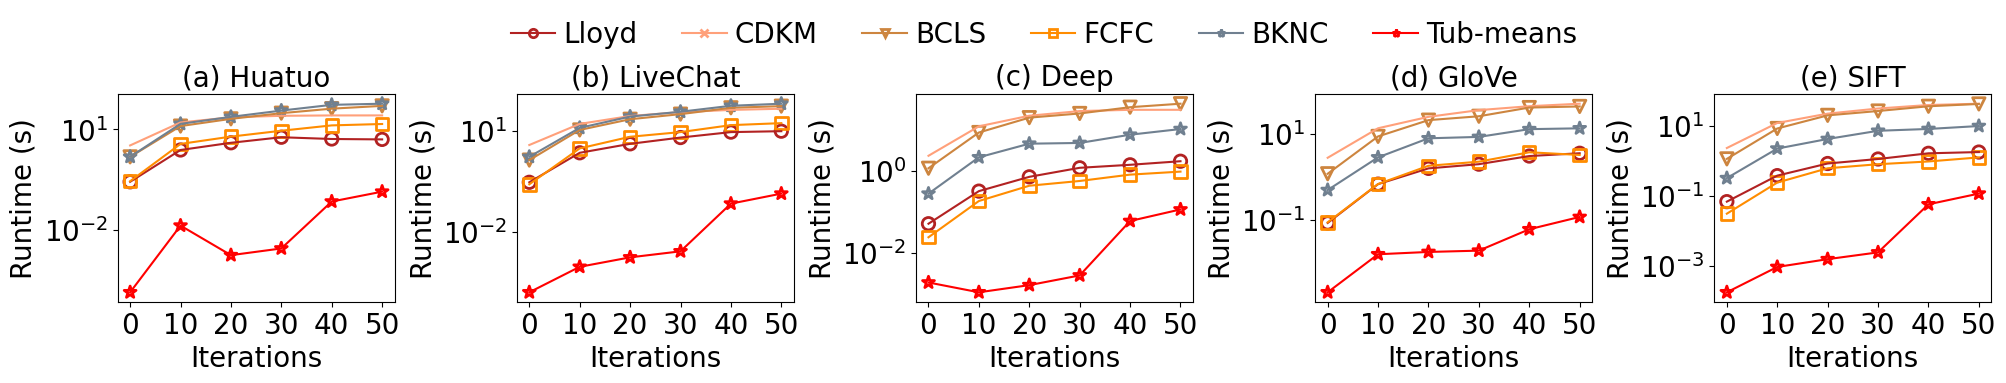

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
from scipy.signal import savgol_filter

# 设置样式和颜色
# colors = ['deepskyblue', 'tomato', 'orange', 'grey', 'olive', 'gold', 'green']
# colors = ['orange', 'tan', 'peru', 'lightsalmon', 'sienna', 'pink', 'red']
colors = [
    '#B22222',  # firebrick
    '#FFA07A',  # lightsalmon
    '#CD853F',  # peru
    '#FF8C00',  # dark orange
    '#708090',  # slate gray
    '#FF0000'  # red
]
marker = ["o", "x", "v", "s", "*", "*"]
markeredgewidth = 2
labels = [
    "Lloyd", "CDKM", "BCLS", "FCFC", "BKNC", "Tub-means"
]

# 读取数据
df = pd.read_csv('iter_performance_results1.csv')
iter_values = [0, 10, 20, 30, 40, 50]  # 你的iter值
datasets = ["Huatuo", "LiveChat", "Deep", "GloVe", "SIFT"]  # 你的数据集名称
num_methods = 6  # 6个方法
fs = 20

# 创建图形
fig, axs = plt.subplots(1, 5, figsize=(20, 3.2))
fig.tight_layout(pad=3.0)

# 平滑函数
def smooth_data(data):
    window_length = min(5, len(data))  # 窗口长度不超过数据长度
    if window_length % 2 == 0:  # 确保是奇数
        window_length -= 1
    polyorder = min(2, window_length-1)  # 多项式阶数
    if len(data) > window_length:
        return savgol_filter(data, window_length, polyorder)
    return data

# 绘制每个数据集的子图
for idx, dataset in enumerate(datasets):
    ax = axs[idx]

    # 设置对数坐标
    ax.set_yscale('log')

    # 强制设置y轴主要刻度为1,10,100
    ax.yaxis.set_major_locator(mticker.FixedLocator([0, 1, 100]))
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

    # 自动调整y轴范围以包含所有数据点
    ax.autoscale(axis='y')

    # 设置坐标轴字体大小
    ax.tick_params(axis='both', which='major', labelsize=fs)
    # ax.tick_params(axis='both', which='minor', labelsize=20)

    # 绘制每个方法的折线
    for method_idx in range(num_methods):
        valid_data = []

        # 新的数据提取逻辑 - 按实际文件结构获取
        for iter_idx, iter_val in enumerate(iter_values):
            # 计算每组起始行：每组6行 × iter组索引
            group_start = iter_idx * 6
            # 数据行在组内的偏移：数据集索引
            data_row = group_start + idx

            if data_row < len(df):
                val = df.iloc[data_row, method_idx]
                try:
                    runtime = float(val) if not pd.isna(val) and str(val).lower() != "error" else np.nan
                    valid_data.append(runtime)
                except:
                    valid_data.append(np.nan)
            else:
                valid_data.append(np.nan)

        # 确保数据长度匹配
        if len(valid_data) == len(iter_values):
            # 绘制折线和点
            linestyle = '-'
            ax.plot(iter_values, valid_data,
                    linestyle=linestyle, color=colors[method_idx], label=labels[method_idx])
            ax.scatter(iter_values, valid_data,
                      marker=marker[method_idx], s=80,
                      edgecolors=colors[method_idx], facecolors='none',
                      linewidths=markeredgewidth)

    # 设置子图标题和标签
    ax.set_title(f"({chr(97+idx)}) {dataset}", fontsize=fs)
    ax.set_xlabel("Iterations", fontsize=fs)
    ax.set_ylabel("Runtime (s)", fontsize=fs)
    # ax.grid(True, linestyle='--', alpha=0.6)

    # 设置y轴为常规小数格式
    # ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))

    # 设置y轴格式
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(mticker.NullFormatter())

    # 设置x轴刻度
    ax.set_xticks(iter_values)
    ax.set_xticklabels(iter_values, fontsize=fs)

    #ax.set_yticks([1, 100])
    #ax.set_yticklabels(["1", "100"], fontsize=fs)
    ax.set_yscale('log')

# 创建图例
handles = []
for idx, (color, marker_style) in enumerate(zip(colors, marker)):
    handle = mlines.Line2D([], [], linestyle='-', color=color, marker=marker_style,
                          markersize=6, markerfacecolor='none', markeredgewidth=markeredgewidth,
                          label=labels[idx])
    handles.append(handle)

fig.legend(
    handles=handles,
    loc='upper center',
    fontsize=fs,
    bbox_to_anchor=(0.5, 1.16),
    ncol=6,
    frameon=False,
    handlelength=1.6,      # 更小的色块
    handletextpad=0.3,     # 更紧凑的文字间距
    columnspacing=1.6      # 更紧凑的列间距
)

# 调整布局
plt.subplots_adjust(wspace=0.44, hspace=0.3)

# 保存和显示
plt.savefig("iter_performance_results1.pdf", format="pdf", bbox_inches="tight")
plt.show()

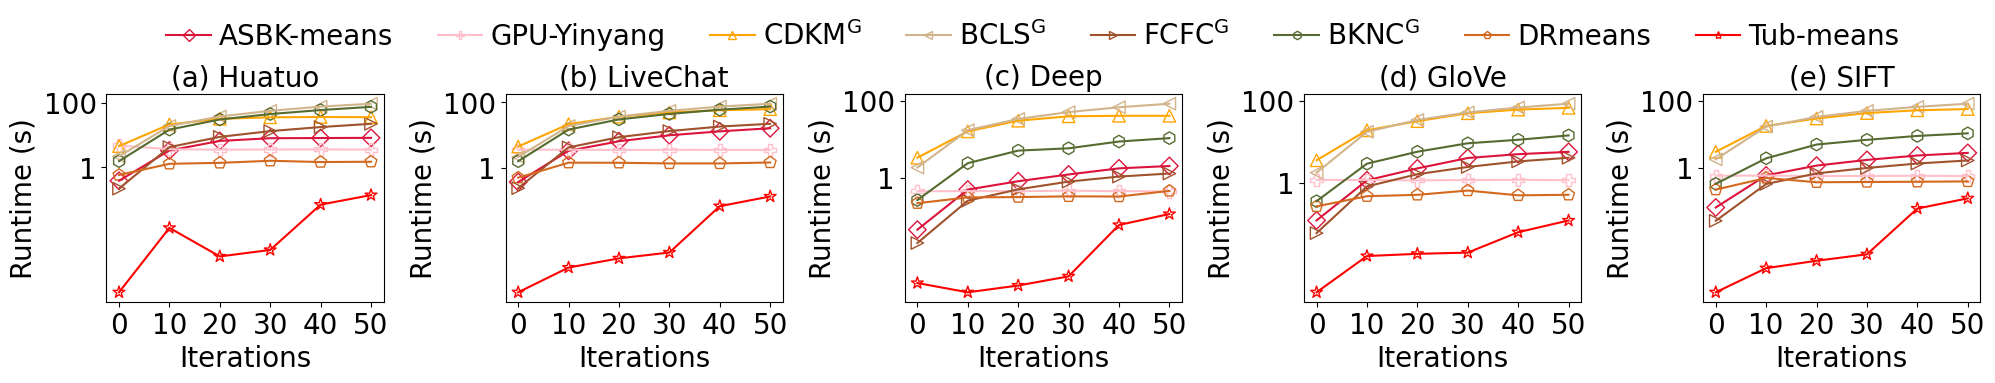

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
from scipy.signal import savgol_filter

# 设置样式和颜色
# colors = ['deepskyblue', 'tomato', 'orange', 'grey', 'olive', 'gold', 'green']
# colors = ['orange', 'tan', 'peru', 'lightsalmon', 'sienna', 'pink', 'red']
colors = [
    '#DC143C',  # crimson
    '#FFC0CB',  # pink
    '#FFA500',  # orange
    '#D2B48C',  # tan
    '#A0522D',  # sienna
    '#556B2F',  # dark olive green
    '#D2691E',  # chocolate
    '#FF0000'  # red
]
marker = ["D", "P", "^", "<", ">", "h", "p", "*"]
markeredgewidth = 1
labels = [
    "ASBK-means", "GPU-Yinyang", "CDKM$^{\\mathrm{G}}$", "BCLS$^{\\mathrm{G}}$", "FCFC$^{\\mathrm{G}}$", "BKNC$^{\\mathrm{G}}$", "DRmeans", "Tub-means"
]

# 读取数据
df = pd.read_csv('iter_performance_results2.csv')
iter_values = [0, 10, 20, 30, 40, 50]  # 你的iter值
datasets = ["Huatuo", "LiveChat", "Deep", "GloVe", "SIFT"]  # 你的数据集名称
num_methods = 8  # 8个方法
fs = 20

# 创建图形
fig, axs = plt.subplots(1, 5, figsize=(20, 3.2))
fig.tight_layout(pad=3.0)

# 平滑函数
def smooth_data(data):
    window_length = min(5, len(data))  # 窗口长度不超过数据长度
    if window_length % 2 == 0:  # 确保是奇数
        window_length -= 1
    polyorder = min(2, window_length-1)  # 多项式阶数
    if len(data) > window_length:
        return savgol_filter(data, window_length, polyorder)
    return data

# 绘制每个数据集的子图
for idx, dataset in enumerate(datasets):
    ax = axs[idx]

    # 设置对数坐标
    ax.set_yscale('log')

    # 强制设置y轴主要刻度为1,10,100
    ax.yaxis.set_major_locator(mticker.FixedLocator([0, 1, 100]))
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

    # 自动调整y轴范围以包含所有数据点
    ax.autoscale(axis='y')

    # 设置坐标轴字体大小
    ax.tick_params(axis='both', which='major', labelsize=fs)
    # ax.tick_params(axis='both', which='minor', labelsize=20)

    # 绘制每个方法的折线
    for method_idx in range(num_methods):
        valid_data = []

        # 新的数据提取逻辑 - 按实际文件结构获取
        for iter_idx, iter_val in enumerate(iter_values):
            # 计算每组起始行：每组6行 × iter组索引
            group_start = iter_idx * 6
            # 数据行在组内的偏移：数据集索引
            data_row = group_start + idx

            if data_row < len(df):
                val = df.iloc[data_row, method_idx]
                try:
                    runtime = float(val) if not pd.isna(val) and str(val).lower() != "error" else np.nan
                    valid_data.append(runtime)
                except:
                    valid_data.append(np.nan)
            else:
                valid_data.append(np.nan)

        # 确保数据长度匹配
        if len(valid_data) == len(iter_values):
            # 绘制折线和点
            linestyle = '-'
            ax.plot(iter_values, valid_data,
                    linestyle=linestyle, color=colors[method_idx], label=labels[method_idx])
            ax.scatter(iter_values, valid_data,
                      marker=marker[method_idx], s=80,
                      edgecolors=colors[method_idx], facecolors='none',
                      linewidths=markeredgewidth)

    # 设置子图标题和标签
    ax.set_title(f"({chr(97+idx)}) {dataset}", fontsize=fs)
    ax.set_xlabel("Iterations", fontsize=fs)
    ax.set_ylabel("Runtime (s)", fontsize=fs)
    # ax.grid(True, linestyle='--', alpha=0.6)

    # 设置y轴为常规小数格式
    # ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))

    # 设置y轴格式
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(mticker.NullFormatter())

    # 设置x轴刻度
    ax.set_xticks(iter_values)
    ax.set_xticklabels(iter_values, fontsize=fs)

# 创建图例
handles = []
for idx, (color, marker_style) in enumerate(zip(colors, marker)):
    handle = mlines.Line2D([], [], linestyle='-', color=color, marker=marker_style,
                          markersize=6, markerfacecolor='none', markeredgewidth=markeredgewidth,
                          label=labels[idx])
    handles.append(handle)

fig.legend(
    handles=handles,
    loc='upper center',
    fontsize=fs,
    bbox_to_anchor=(0.5, 1.16),
    ncol=8,
    frameon=False,
    handlelength=1.6,      # 更小的色块
    handletextpad=0.3,     # 更紧凑的文字间距
    columnspacing=1.6      # 更紧凑的列间距
)
# 调整布局
plt.subplots_adjust(wspace=0.44, hspace=0.3)

# 保存和显示
plt.savefig("iter_performance_results2.pdf", format="pdf", bbox_inches="tight")
plt.show()